# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import jit

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


# Defining the functions(GENERAL)

## Parameter initialization

In [5]:
def params_init_seeded(seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [6]:
def params_init():

  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

## Other generic functions egs-loss

In [7]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [8]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre)), axis = 0)
  return loss

## Forward pass

In [9]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

## Param update

In [10]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

# Back propagation

In [11]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [12]:
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      if (i+1)%4==0:
        plt.figure()
        plt.subplot(2,2 ,1)
        plt.hist(W1.flatten(), bins = 30)
        plt.subplot(2,2 ,2)
        plt.hist(W2.flatten(), bins = 30)
        plt.subplot(2,2, 3)
        plt.hist(b1.flatten(), bins = 30)
        plt.subplot(2,2, 4)
        plt.hist(b2.flatten(), bins = 30)

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [ ]:
break code here;

SyntaxError: invalid syntax (1393473991.py, line 1)

Params Initialised
Iteration: 1
Train accuracy: 18.99047619047619
Val accuracy: 18.97142857142857
Iteration: 2
Train accuracy: 35.2047619047619
Val accuracy: 34.542857142857144
Iteration: 3
Train accuracy: 47.60634920634921
Val accuracy: 47.714285714285715
Iteration: 4
Train accuracy: 55.77142857142857
Val accuracy: 55.72857142857143
Iteration: 5
Train accuracy: 61.28888888888889
Val accuracy: 61.25714285714285
Iteration: 6
Train accuracy: 65.21746031746032
Val accuracy: 64.91428571428571
Iteration: 7
Train accuracy: 68.26825396825397
Val accuracy: 67.88571428571429
Iteration: 8
Train accuracy: 70.64444444444445
Val accuracy: 70.19999999999999
Iteration: 9
Train accuracy: 72.62063492063491
Val accuracy: 71.82857142857144
Iteration: 10
Train accuracy: 74.08888888888889
Val accuracy: 73.34285714285714
Iteration: 11
Train accuracy: 75.36031746031746
Val accuracy: 74.71428571428571
Iteration: 12
Train accuracy: 76.38571428571429
Val accuracy: 75.72857142857143
Iteration: 13
Train accuracy:

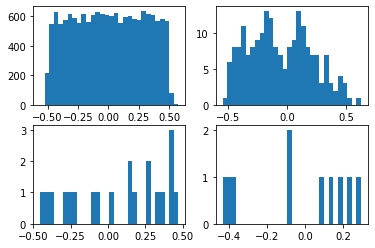

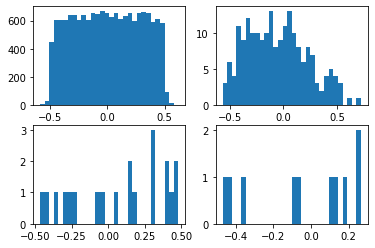

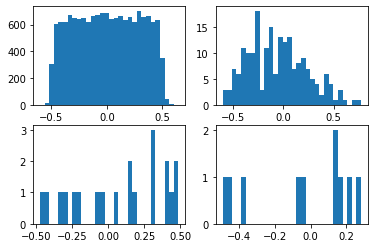

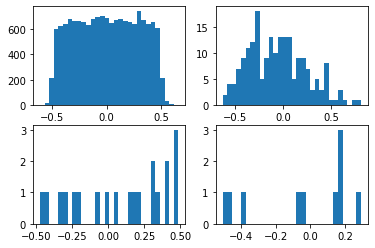

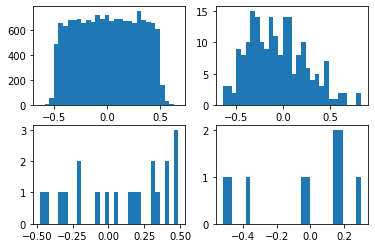

In [267]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,20, 0.01, print_op=1);

# Weight perturbation

In [13]:
def WP(W1, b1, W2, b2, pert, lossBeforePert, X, y):
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pert = W1.copy()
            W1pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1pert, b1, W2, b2)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)
    for i in range(b1.shape[0]):
        b1pert = b1.copy()
        b1pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1pert, W2, b2)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pert = W2.copy()
            W2pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1, b1, W2pert, b2)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)
    for i in range(b2.shape[0]):
        b2pert = b2.copy()
        b2pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1, W2, b2pert)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [14]:
def batch_grad_descentWP(X,Y,iter, lr, pert, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 
      print(f"BP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [ ]:
pertList = [0.1, 0.01, 0.001, 0.0001]
trainAccWP = []
valAccWP = []
for pert in pertList:
    _, _, _, _, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descentWP(x_train,y_train,5, 0.1, pert = pert, print_op=1);
    trainAccWP.append(train_acc)
    valAccWP.append(val_acc)

Params Initialised


KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy vs epochs for different techiques')

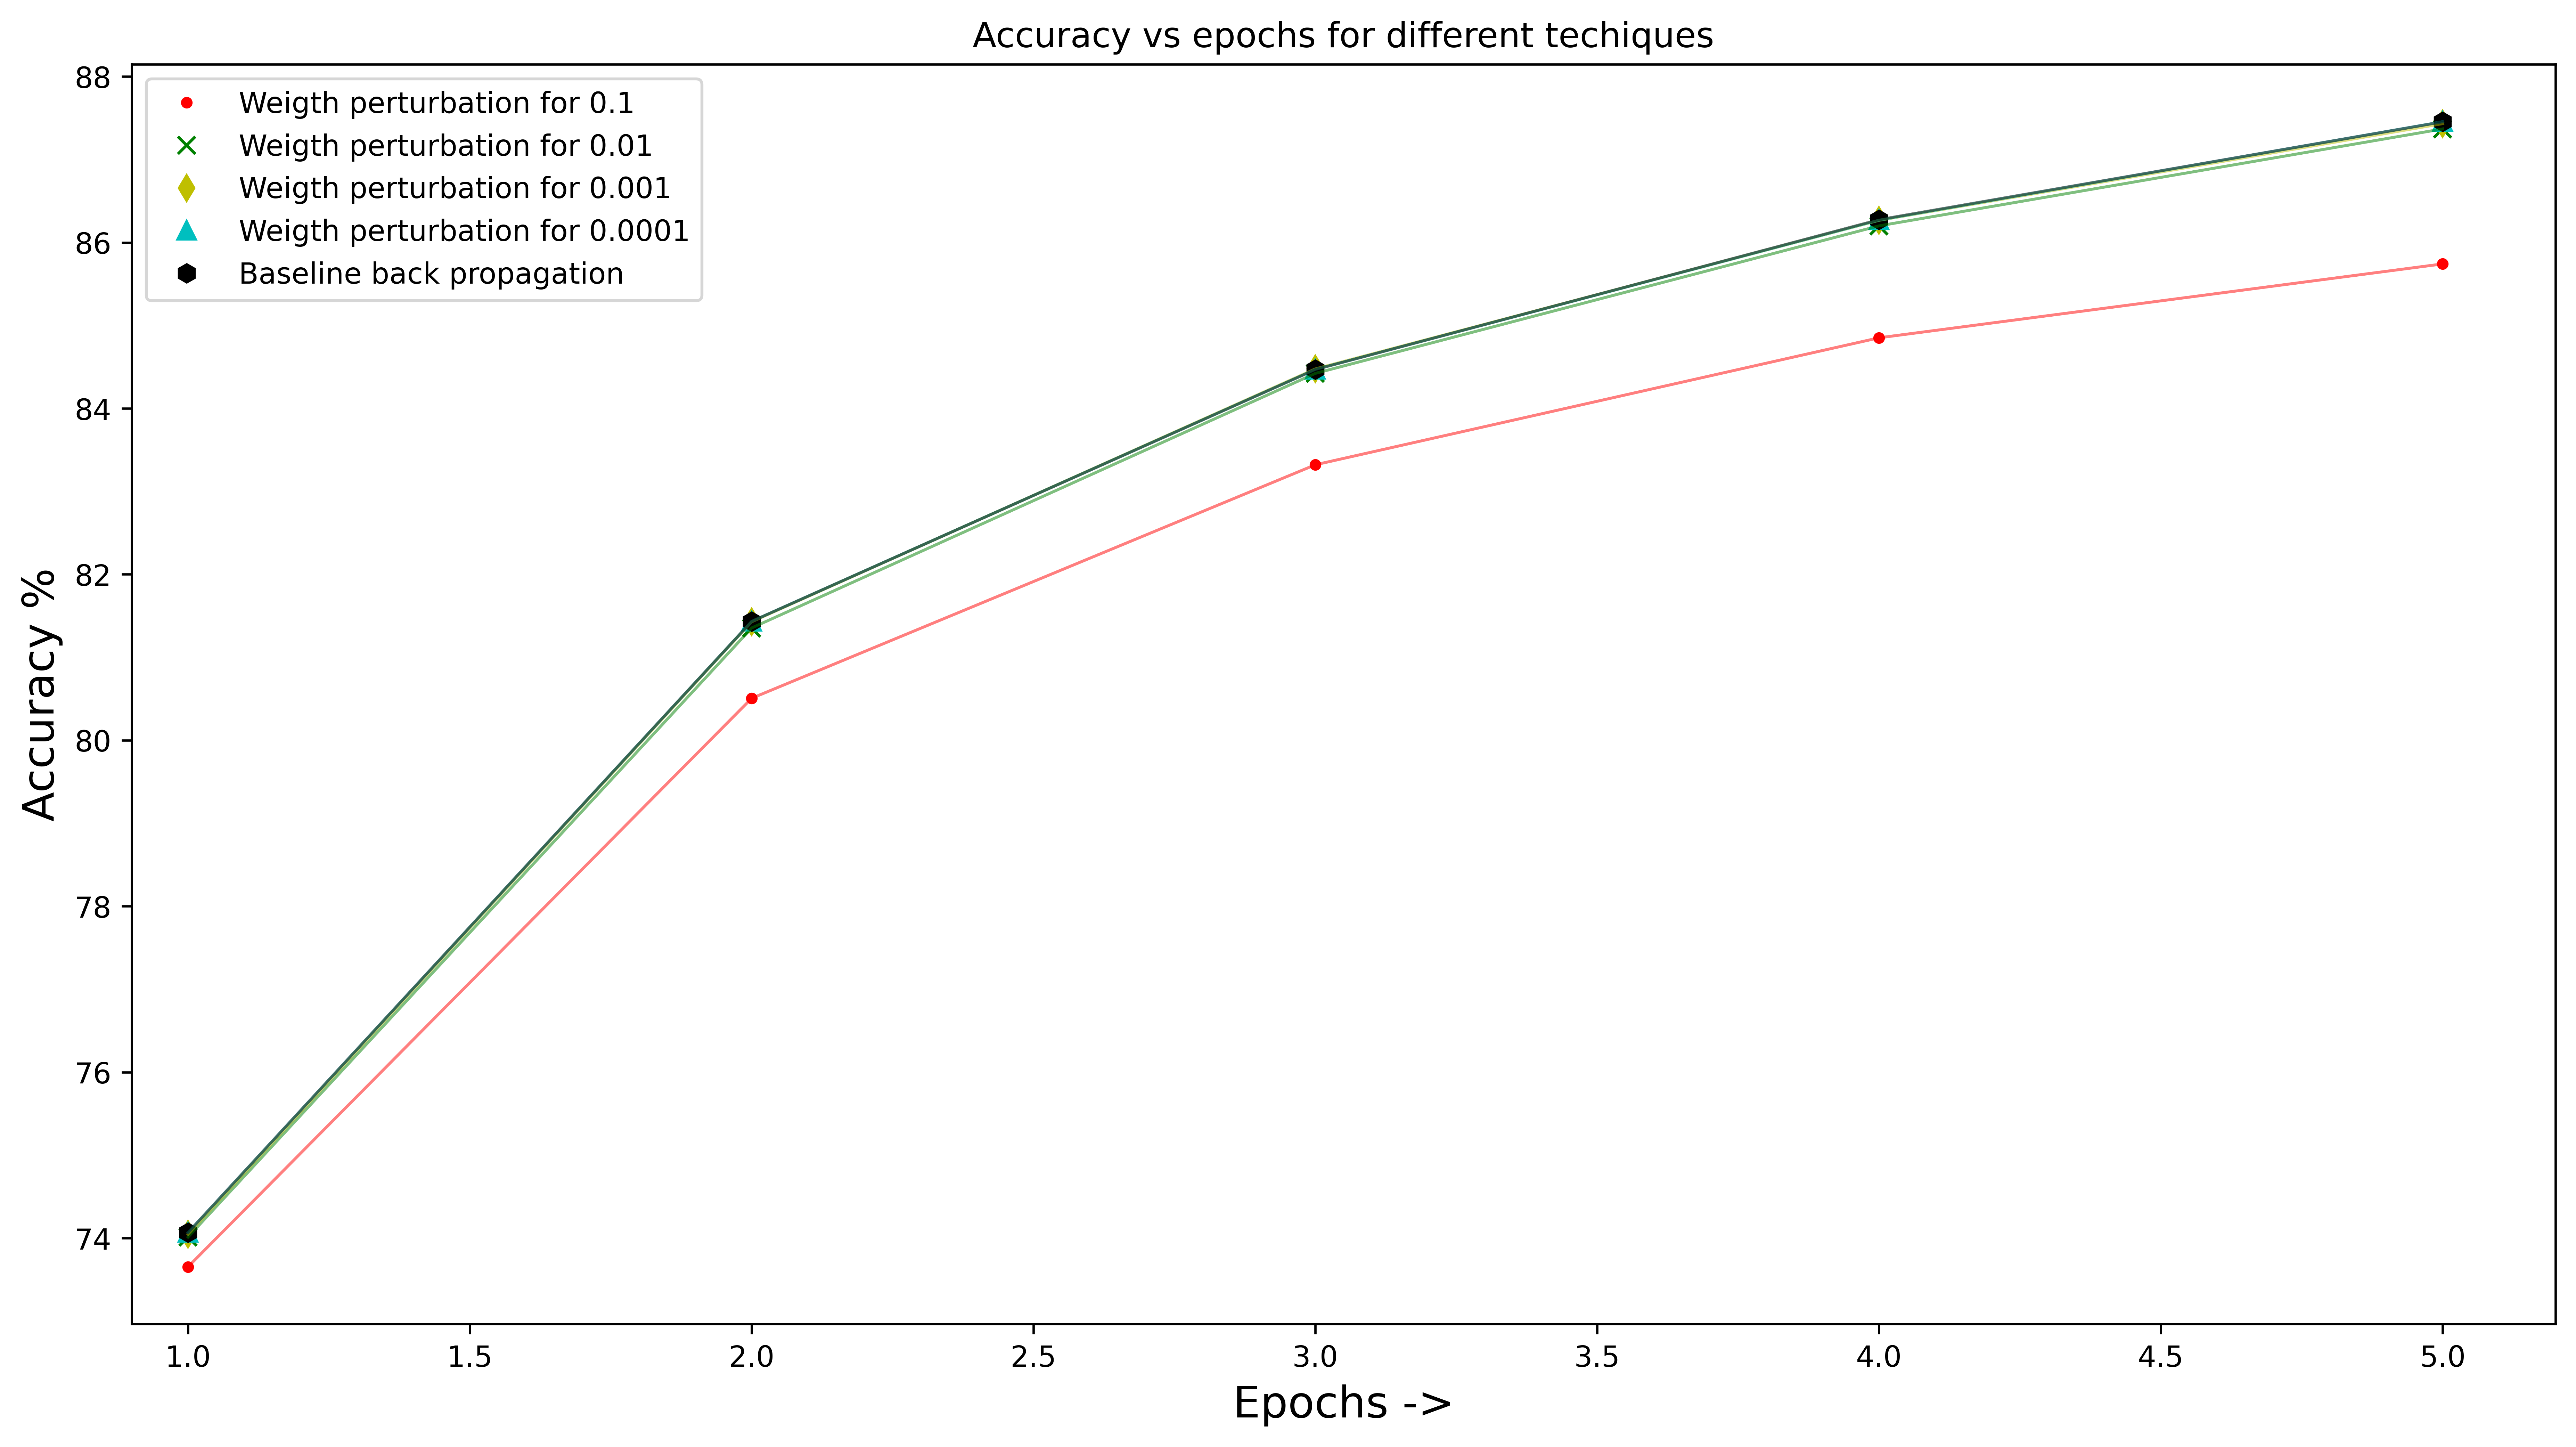

In [ ]:
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(15, 8))
format = ['r.', 'gx', 'yd', 'c^']
col = ['r', 'g', 'y', 'c']
leg = []
epochList = [i+1 for i in range(5)]
for _ in range(len(pertList)):
    plt.plot(epochList, trainAccWP[_], format[_])
    leg.append(f"Weigth perturbation for {pertList[_]}")
plt.plot(epochList, train_accBP, 'kh')
leg.append("Baseline back propagation")
for _ in range(len(pertList)):
    plt.plot(epochList, trainAccWP[_], col[_], linewidth=1, alpha = 0.5)
plt.plot(epochList, train_accBP, 'k', linewidth=1, alpha = 0.5)
plt.legend(leg)
plt.xlim(left = 0.9)
plt.xlabel("Epochs ->", size = 15)
plt.ylabel("Accuracy %", size = 15)
plt.title("Accuracy vs epochs for different techiques")

In [ ]:
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(12, 8))
format = ['r.', 'gx', 'yd', 'c^']
col = ['r', 'g', 'y', 'c']
leg = []
epochList = [i for i in range(5)]
for _ in range(1, len(pertList)):
    plt.plot(epochList[3:], trainAccWP[_][3:], format[_])
    leg.append(f"Weight perturbation for {pertList[_]}")
plt.plot(epochList[3:], train_accBP[3:], 'kh')
leg.append("Baseline back propagation")
for _ in range(1, len(pertList)):
    plt.plot(epochList[3:], trainAccWP[_][3:], col[_], linewidth=1, alpha = 0.5)
plt.plot(epochList[3:], train_accBP[3:], 'k', linewidth=1, alpha = 0.5)
plt.legend(leg)
plt.xlim(left = 2.9)
plt.xlabel("Epochs ->", size = 15)
plt.ylabel("Accuracy %", size = 15)
plt.title("Accuracy vs epochs for different techiques")

Text(0.5, 1.0, 'Accuracy vs epochs for different techiques')

## Adding variabilty

### Generic functions related to variability

In [15]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [16]:
def getVth(mu, sigma, shape):
  #last dimension represents the binary rep for each weight
  print(shape)
  return np.random.normal(loc=mu, scale=sigma, size=shape) #each bit is represented by an sram so we need those many vth values for each mosfet in this set

In [17]:
def initMosParam(shape, mu, sigma, vDD, precision, k=100):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    return (iOn, iOnNominal, iOff)

In [18]:
def clippedWeight(weightArray, precision, step, discreteSteps):
    return np.multiply(np.sign(weightArray), np.digitize(np.abs(weightArray), discreteSteps))*step

In [19]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [20]:
# refer to https://stackoverflow.com/questions/9958506/element-wise-string-concatenation-in-numpy

## NEED TO CORRECT IT FOR A NEGATIVE VALUES OF THE WEIGHT ARRAY!!!!
def weigthBitArray(weightArray, precision, discreteSteps):
    clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights

    iniArr = np.where(np.bitwise_and(clippedWeightIndexArray, 2**0)>=1, '1', '0') #array of bits at level 0 (2^0)

    for j in range(1, precision):
        iniArr = np.core.defchararray.add(np.where(np.bitwise_and(clippedWeightIndexArray, 2**j)>=1, '1', '0'), iniArr)
    return iniArr

In [21]:
def batchGDCompOC(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init(2)

  W1bp, b1bp, W2bp, b2bp= W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()

  W1wp, b1wp, W2wp, b2wp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)



  dW1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  db1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  dW2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  db2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    # w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    # b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    # w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    # b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    # w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    # b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    print(cosine_similarity(W1bp.reshape(1,-1), W1wp.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      W1varocwp = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps)
      b1varocwp = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps)
      W2varocwp = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps)
      b2varocwp = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps)

      #W1comp.append([W1np[0, 0], W1varocwp[0, 0]])
      

      #print(W2varocwp)
      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"WP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)
      lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      #dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varocnp, W2varocnp, W3varocnp,b1varocnp, b2varocnp, b3varocnp, X1, Y1)
      #print(f"iter in iter{j}")
      #dW1wp, db1wp, dW2wp, db2wp = WP(W1varocwp, b1varocwp, W2varocwp, b2varocwp, pert, lossBeforePert, X1, Y1)
      dW1wp, db1wp, dW2wp, db2wp = WP(W1wp, b1wp, W2wp, b2wp, pert, lossBeforePert, X1, Y1)


      dW1varocwp = weightTransformWithVariability(dW1wp, dW1Currents, precision, step, discreteSteps)
      db1varocwp = weightTransformWithVariability(db1wp.reshape(db1wp.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocwp = weightTransformWithVariability(dW2wp, dW2Currents, precision, step, discreteSteps)
      db2varocwp = weightTransformWithVariability(db2wp.reshape(db2wp.shape[0],1), db2Currents, precision, step, discreteSteps)



      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1wp, db1wp, dW2wp, db2wp, lr = lrNP)
      #print(W1wp)
      ###print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)




      #doing the back propagation for the same data set sample

      W1varocbp = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps)
      b1varocbp = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps)
      W2varocbp = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps)
      b2varocbp = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps)

      Z1, A1, Z2, A2 = forward(X1, W1varocbp, b1varocbp, W2varocbp,b2varocbp) 
      print(f"                                                                        BP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1),3)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1bp, W2bp, X1, Y1)
      #print(f"iter in iter{j}")


      dW1varocbp = weightTransformWithVariability(dW1bp, dW1Currents, precision, step, discreteSteps)
      db1varocbp = weightTransformWithVariability(db1bp.reshape(db1bp.shape[0],1), db1Currents, precision, step, discreteSteps)
      dW2varocbp = weightTransformWithVariability(dW2bp, dW2Currents, precision, step, discreteSteps)
      db2varocbp = weightTransformWithVariability(db2bp.reshape(db2bp.shape[0],1), db2Currents, precision, step, discreteSteps)


      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp, dW1bp, db1bp, dW2bp, db2bp,  lr = lrBP)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, A2_train = forward(X, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_train_bp = forward(X, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([accuracy(predictions(A2_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([accuracy(predictions(A2_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [22]:
iter=1
lrBP=0.01
lrNP=0.01
pert=0.01
mu = 0.7
sigma = 0.01
vDD = 5
precision = 8#setting the precision value of the calculations
wRange = 2
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

## Plotting the extent of variability

In [24]:
Curr = initMosParam((1,1), mu, sigma, vDD, precision)

In [25]:
p =np.array([[-1.94385,5.64389], [3.14,4.545909]])


In [127]:
p = np.array([i for i in np.arange(-2, 2.0, 0.04)])
p = p.reshape((10, 10))

In [128]:
p

array([[-2.00000000e+00, -1.96000000e+00, -1.92000000e+00,
        -1.88000000e+00, -1.84000000e+00, -1.80000000e+00,
        -1.76000000e+00, -1.72000000e+00, -1.68000000e+00,
        -1.64000000e+00],
       [-1.60000000e+00, -1.56000000e+00, -1.52000000e+00,
        -1.48000000e+00, -1.44000000e+00, -1.40000000e+00,
        -1.36000000e+00, -1.32000000e+00, -1.28000000e+00,
        -1.24000000e+00],
       [-1.20000000e+00, -1.16000000e+00, -1.12000000e+00,
        -1.08000000e+00, -1.04000000e+00, -1.00000000e+00,
        -9.60000000e-01, -9.20000000e-01, -8.80000000e-01,
        -8.40000000e-01],
       [-8.00000000e-01, -7.60000000e-01, -7.20000000e-01,
        -6.80000000e-01, -6.40000000e-01, -6.00000000e-01,
        -5.60000000e-01, -5.20000000e-01, -4.80000000e-01,
        -4.40000000e-01],
       [-4.00000000e-01, -3.60000000e-01, -3.20000000e-01,
        -2.80000000e-01, -2.40000000e-01, -2.00000000e-01,
        -1.60000000e-01, -1.20000000e-01, -8.00000000e-02,
        -4.

In [123]:
roundArbitrary(p, step, wRange)

array([[-2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ],
       [-2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ],
       [-2.        , -2.        , -2.        , -2.        , -2.        ,
        -2.        , -2.        , -2.        , -2.        , -2.        ],
       [-2.        , -1.86666667, -1.86666667, -1.73333333, -1.6       ,
        -1.46666667, -1.46666667, -1.33333333, -1.2       , -1.06666667],
       [-1.06666667, -0.93333333, -0.8       , -0.66666667, -0.66666667,
        -0.53333333, -0.4       , -0.26666667, -0.26666667, -0.13333333],
       [-0.        ,  0.13333333,  0.13333333,  0.26666667,  0.4       ,
         0.53333333,  0.53333333,  0.66666667,  0.8       ,  0.93333333],
       [ 0.93333333,  1.06666667,  1.2       ,  1.33333333,  1.33333333,
         1.46666667,  1.6       ,  1.73333333

In [132]:
plt.figure(figsize = (12, 8))
plt.plot(p.flatten(), roundArbitrary(p, step, wRange).flatten(), '.')
plt.xlim([-2, 2])
plt.ylim([-2, 2])

(-2.0, 2.0)

In [35]:
p  = np.r_[np.array(discreteSteps)*(-1), discreteSteps]

In [36]:
p = p.reshape((p.shape[0],1))

In [133]:
Curr = initMosParam(p.shape, mu, sigma, vDD, precision)
Curr

(array([[[0.01625505, 0.01173575, 0.01157779, 0.0204183 , 0.01544664,
          0.01418207, 0.01081441, 0.01723632],
         [0.01477601, 0.01927324, 0.01338551, 0.01496523, 0.02328221,
          0.01838203, 0.01423829, 0.01604697],
         [0.01296086, 0.00996015, 0.01867857, 0.01182859, 0.02586223,
          0.01493121, 0.01168122, 0.01377736],
         [0.01768764, 0.01733166, 0.02177349, 0.01657814, 0.03038056,
          0.0232467 , 0.0108152 , 0.01539875],
         [0.01724217, 0.02134592, 0.02495906, 0.01781216, 0.01686259,
          0.01929248, 0.01597346, 0.01942005],
         [0.01065888, 0.01587333, 0.00897068, 0.01977791, 0.01123028,
          0.02479502, 0.02180056, 0.0199978 ],
         [0.01731768, 0.02193502, 0.02334801, 0.01435978, 0.01772645,
          0.01791397, 0.01873585, 0.0179248 ],
         [0.01668299, 0.02450751, 0.02612482, 0.0147372 , 0.00849842,
          0.01436795, 0.01523302, 0.01376085],
         [0.01454693, 0.01562399, 0.02051771, 0.01332867, 0.0136

In [31]:
Curr[1]

0.016506206522006208

In [ ]:
a, b, c  = Curr[-1].shape
Curr[-1].sum()/(a*b*c)

0.00016701007466043426

In [ ]:
p

array([-0.00000000e+00, -1.52590219e-05, -3.05180438e-05, ...,
        9.99954223e-01,  9.99969482e-01,  9.99984741e-01])

In [57]:
weightTransformWithVariability(p, Curr, precision, step, discreteSteps, wRange)

IndexError: index 5 is out of bounds for axis 2 with size 5

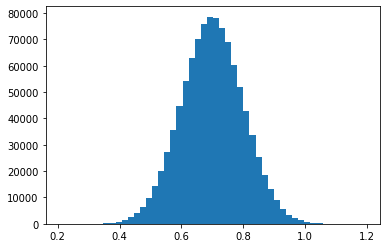

In [ ]:
vth = np.random.normal(loc=mu, scale=0.1, size = (1000, 1000));
plt.hist(vth.flatten(), bins = 50);

In [68]:
p[-1, -1] = 10

In [69]:
p

array([[-2.00000000e+00, -1.96000000e+00, -1.92000000e+00,
        -1.88000000e+00, -1.84000000e+00, -1.80000000e+00,
        -1.76000000e+00, -1.72000000e+00, -1.68000000e+00,
        -1.64000000e+00],
       [-1.60000000e+00, -1.56000000e+00, -1.52000000e+00,
        -1.48000000e+00, -1.44000000e+00, -1.40000000e+00,
        -1.36000000e+00, -1.32000000e+00, -1.28000000e+00,
        -1.24000000e+00],
       [-1.20000000e+00, -1.16000000e+00, -1.12000000e+00,
        -1.08000000e+00, -1.04000000e+00, -1.00000000e+00,
        -9.60000000e-01, -9.20000000e-01, -8.80000000e-01,
        -8.40000000e-01],
       [-8.00000000e-01, -7.60000000e-01, -7.20000000e-01,
        -6.80000000e-01, -6.40000000e-01, -6.00000000e-01,
        -5.60000000e-01, -5.20000000e-01, -4.80000000e-01,
        -4.40000000e-01],
       [-4.00000000e-01, -3.60000000e-01, -3.20000000e-01,
        -2.80000000e-01, -2.40000000e-01, -2.00000000e-01,
        -1.60000000e-01, -1.20000000e-01, -8.00000000e-02,
        -4.

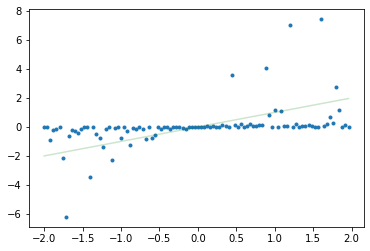

In [135]:
Curr = initMosParam(p.shape, mu, 0.1, vDD, precision, 10)
pVar = weightTransformWithVariability(p, Curr, precision, step, discreteSteps, wRange).reshape((1, -1))
plt.plot(p.flatten(), pVar.flatten(), '.')
plt.plot(p.flatten(), p.flatten(), 'g', alpha = 0.2)

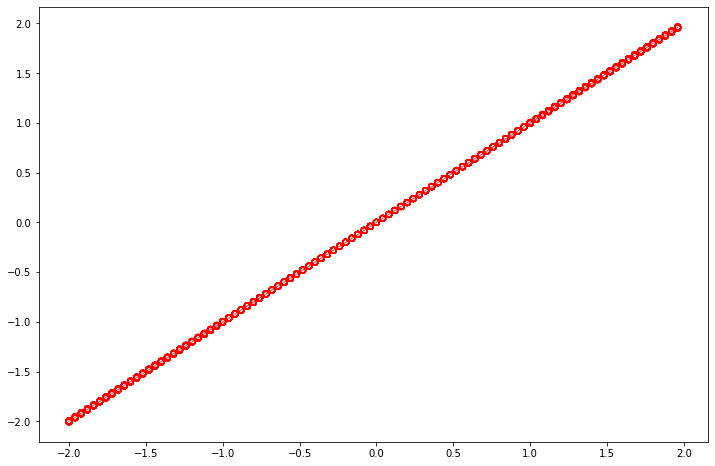

In [159]:
plt.figure(figsize=(12, 8))
#plt.gcf().set_dpi(300)
plt.plot(p.flatten(), p.flatten(), 'r', linewidth=1, alpha = 0.8)
for _ in range(100):
    Curr = initMosParam(p.shape, mu, 0.0001, vDD, precision, 10000000)
    pVar = weightTransformWithVariability(p, Curr, precision, step, discreteSteps, wRange)
    plt.scatter(p.flatten(), pVar.flatten(), facecolors='none', edgecolors='r')

In [ ]:
p = np.array([[2.745, -5.4324],[6.89, -7.923095]])
roundArbitrary(p, step)/step

array([[  562., -1111.],
       [ 1410., -1621.]])

In [ ]:
curr = initMosParam((1000,1000), mu, 0.01, vDD, precision)

In [ ]:
np.max(curr[0])

0.062467830375822105

In [ ]:
plt.hist(curr[0].flatten(), bins = 100);

In [ ]:
x = np.array([0.5])
x = x.reshape((1,1))
pVarList = []
for _ in range(10000):
    Curr = initMosParam(x.shape, mu, 0.01, vDD, precision, k = 10)
    pVar = weightTransformWithVariability(x, Curr, precision, step, discreteSteps, wRange)
    pVarList.append(pVar[0, 0])

In [ ]:
x//step

array([[32767.]])

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(pVarList, bins=50, alpha=0.4);
plt.axvline(x[0, 0], color = 'r', linestyle='--', linewidth=0.5)
plt.axvline(np.mean(np.array(pVarList)), color = 'g', linestyle='--', linewidth=0.5)

In [ ]:
p[10, 0], roundArbitrary(p[101, 0], step, wRange)

(-0.00015259021896696422, -0.0015411612115663385)

-0.0015259021896696422

## Weight perturbation with variability(function needs update)

In [23]:
iter=1
lrBP=1
lrNP=1
pert=0.01
mu = 0.7
sigma = 0.01
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 2
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

In [24]:
def WPwithVar(W1, b1, W2, b2, pert, lossBeforePert, X, y, precision, step, discreteSteps, wRange,  W1Var, b1Var, W2Var, b2Var, W1Currents, b1Currents, W2Currents, b2Currents):
    #assert pert==step #to get increments of '1' in the bit pattern of the weight array
    #! here the perturbation is wrong since we are generating a new different weight array everytime
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pert = W1.copy()
            W1pert[i, j] += pert
            #do the transform only on that perturbed weight and place it in the correct place
            W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1pertArrTr, b1Var, W2Var, b2Var)
            #print(A2pert)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    #print(lossAfterPertW1)
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)
    for i in range(b1.shape[0]):
        b1pert = b1.copy()
        b1pert[i]+=pert
        b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1pertArrTr, W2Var, b2Var)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pert = W2.copy()
            W2pert[i, j] += pert
            W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1Var, b1Var, W2pertArrTr, b2Var)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)
    for i in range(b2.shape[0]):
        b2pert = b2.copy()
        b2pert[i]+=pert
        b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1Var, W2Var, b2pertArrTr)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [25]:
def WPwithVarUp(W1, b1, W2, b2, pert, lossBeforePert, X, y, precision, step, discreteSteps, wRange,  W1Var, b1Var, W2Var, b2Var, W1Currents, b1Currents, W2Currents, b2Currents):
    #assert pert==step #to get increments of '1' in the bit pattern of the weight array
    #!here we chnage perturb only one value
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    
    W1pert = W1.copy()
    W1pert += pert
    W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pertLoop = W1Var.copy()
            W1pertLoop[i, j] = W1pertArrTr[i, j]
            #print(W1pertLoop - W1Var)
            #plt.figure()
            #plt.plot(W1Var.flatten(), W1pertLoop.flatten(), '.')
            #plt.title("W1 comp")
            #do the transform only on that perturbed weight and place it in the correct place
            #W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1pertLoop, b1Var, W2Var, b2Var)
            #print(A2pert)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert
    #print(lossAfterPertW1-lossBeforePert)


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)

    b1pert = b1.copy()
    b1pert +=pert
    b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)

    for i in range(b1.shape[0]):
        b1pertLoop = b1Var.copy()
        b1pertLoop[i]=b1pertArrTr[i]
        #b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1pertLoop, W2Var, b2Var)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)

    W2pert = W2.copy()
    W2pert += pert
    W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pertLoop = W2Var.copy()
            W2pertLoop[i, j] = W2pertArrTr[i, j]
            #W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1Var, b1Var, W2pertLoop, b2Var)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert
    #print(lossAfterPertW2)


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)

    b2pert = b2.copy()
    b2pert += pert
    b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)


    for i in range(b2.shape[0]):
        b2pertLoop = b2Var.copy()
        b2pertLoop[i] = b2pertArrTr[i]
        #b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1Var, W2Var, b2pertLoop)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

Now everthing should be maintained in bits!

In [26]:
def batchGDCompOCUp(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init()

  W1bp, b1bp, W2bp, b2bp= W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()
  W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
  b1bp = roundArbitrary(b1bp, step, wRange)
  W2bp = roundArbitrary(W2bp, step, wRange)
  b2bp = roundArbitrary(b2bp, step, wRange)
  

  W1wp, b1wp, W2wp, b2wp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()
  W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
  b1wp = roundArbitrary(b1wp, step, wRange)
  W2wp = roundArbitrary(W2wp, step, wRange)
  b2wp = roundArbitrary(b2wp, step, wRange)


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, k =1000000)#k = Ion/Ioff
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, k =1000000)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, k =1000000)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =101000000)



  dW1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  db1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  dW2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  db2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    # w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    # b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    # w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    # b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    # w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    # b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    print(cosine_similarity(W1bp.reshape(1,-1), W1wp.reshape(1,-1))[0][0])
    for j in range(5): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      
      W1varocwp = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      b1varocwp = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      W2varocwp = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      b2varocwp = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)

      #W1comp.append([W1np[0, 0], W1varocwp[0, 0]])
      #plt.figure()
      #plt.plot(W1wp.flatten(), W1varocwp.flatten(), '.')
      #print(W1varocwp)
      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"WP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)
      lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))


      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      #dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varocnp, W2varocnp, W3varocnp,b1varocnp, b2varocnp, b3varocnp, X1, Y1)
      #print(f"iter in iter{j}")
      #dW1wp, db1wp, dW2wp, db2wp = WP(W1varocwp, b1varocwp, W2varocwp, b2varocwp, pert, lossBeforePert, X1, Y1)
      dW1wp, db1wp, dW2wp, db2wp = WPwithVarUp(W1wp, b1wp, W2wp, b2wp, pert, lossBeforePert, X1, Y1, precision, step, discreteSteps,  wRange, W1varocwp, b1varocwp, W2varocwp, b2varocwp, W1Currents, b1Currents, W2Currents, b2Currents)
      #print(dW1wp)
      #print(W1roundwp/step)

      dW1roundwp = roundArbitrary(dW1wp, step, wRange)#weights have to maintained as their digitized versions
      db1roundwp = roundArbitrary(db1wp, step, wRange)
      dW2roundwp = roundArbitrary(dW2wp, step, wRange)
      db2roundwp = roundArbitrary(db2wp, step, wRange)
      



      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1roundwp, db1roundwp, dW2roundwp, db2roundwp, lr = lrNP)
      W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
      b1wp = roundArbitrary(b1wp, step, wRange)
      W2wp = roundArbitrary(W2wp, step, wRange)
      b2wp = roundArbitrary(b2wp, step, wRange)
      #print(dW1wp/step)
      #print(W1wp)
      ###print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)




      #doing the back propagation for the same data set sample

      W1varocbp = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      b1varocbp = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      W2varocbp = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      b2varocbp = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)
      

      Z1, A1, Z2, A2 = forward(X1, W1varocbp, b1varocbp, W2varocbp,b2varocbp)
      #print(A2) 
      print(f"                                                                        BP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1),3)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1varocbp, W2varocbp, X1, Y1)
      #print(dW1bp)
      #print(f"iter in iter{j}")


      dW1roundbp = roundArbitrary(dW1bp, step, wRange)#weights have to maintained as their digitized versions
      db1roundbp = roundArbitrary(db1bp, step, wRange)
      dW2roundbp = roundArbitrary(dW2bp, step, wRange)
      db2roundbp = roundArbitrary(db2bp, step, wRange)


      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp, dW1roundbp, db1roundbp, dW2roundbp, db2roundbp,  lr = lrBP)
      W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
      b1bp = roundArbitrary(b1bp, step, wRange)
      W2bp = roundArbitrary(W2bp, step, wRange)
      b2bp = roundArbitrary(b2bp, step, wRange)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()
      plt.figure()
      plt.plot(dW1bp.flatten(), dW1wp.flatten(), '.')
      plt.title(f"Iter {j}")
      #plt.plot(dW1roundbp.flatten(), dW1roundwp.flatten(), '.', alpha = 0.3)


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      # plt.figure()
      # plt.plot(W1bp.flatten())
      # plt.plot(W1wp.flatten())
      # plt.legend(["BP", "Wp"])
      _, _, _, A2_train = forward(X, weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange))
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):

       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([accuracy(predictions(A2_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([accuracy(predictions(A2_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

1. Compare software WP with WP with qaunization with different values of precision - plot
2. You shld see the above converge for some bit precision value => quantization is not critical
3. Then at this add different variability to see that at which variability it matches with the above WP (2)
4. same for bP


#update 9/21/2022
1. See the weight updates in each of the cases with quantizaion - see whether weights add soemthing
2. errors in bits

Params Initialised
0.9999999999999997
Iteration: 1::Train accuracy: 36.992::Val accuracy: 37.386:#########################:Train Acc BP::36.99 Val Acc BP::37.386


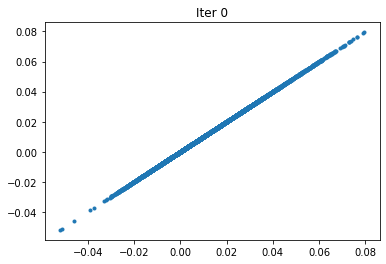

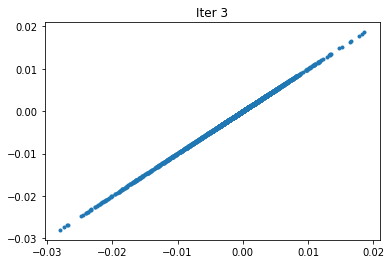

In [108]:
tt = []
for i in range(1):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,1, lrBP, lrNP, step, mu, 0, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt.append(trainAccVar)

In [47]:
tt1 = []
#case for kinda high variabiity with very high Ion/Ioff ration(ideal Ion/Ioff ratio)
for i in range(5):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,1, lrBP, lrNP, step, mu, 0.0001, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt1.append(trainAccVar)

Params Initialised
0.9999999999999982
Iteration: 1::Train accuracy: 88.638::Val accuracy: 88.671:#########################:Train Acc BP::88.867 Val Acc BP::87.871
Params Initialised
0.9999999999999998
Iteration: 1::Train accuracy: 88.538::Val accuracy: 88.143:#########################:Train Acc BP::88.448 Val Acc BP::87.986
Params Initialised
1.0000000000000004
Iteration: 1::Train accuracy: 85.962::Val accuracy: 85.457:#########################:Train Acc BP::84.214 Val Acc BP::83.686
Params Initialised
1.0000000000000016
Iteration: 1::Train accuracy: 87.022::Val accuracy: 86.686:#########################:Train Acc BP::87.178 Val Acc BP::83.9
Params Initialised
1.0000000000000009
Iteration: 1::Train accuracy: 85.708::Val accuracy: 86.029:#########################:Train Acc BP::85.554 Val Acc BP::83.343


Params Initialised
0.9999999999999972
Iteration: 1::Train accuracy: 9.308::Val accuracy: 9.171:#########################:Train Acc BP::9.308 Val Acc BP::9.171
0.9999999999999972
Iteration: 2::Train accuracy: 9.308::Val accuracy: 9.171:#########################:Train Acc BP::9.308 Val Acc BP::9.171


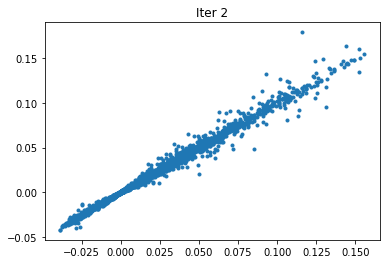

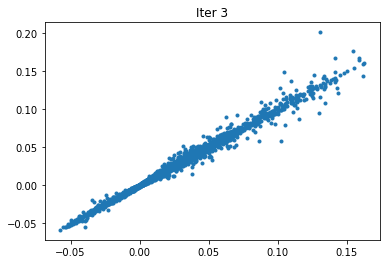

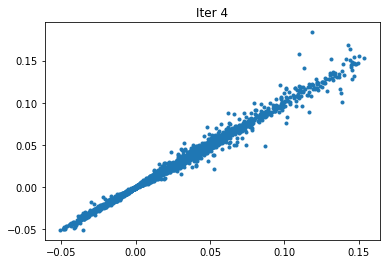

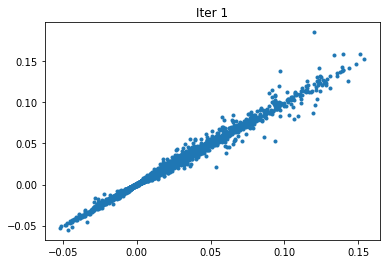

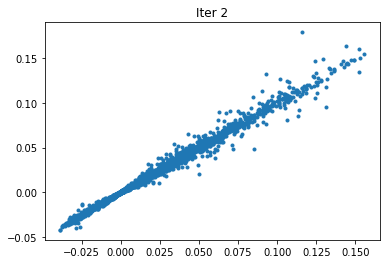

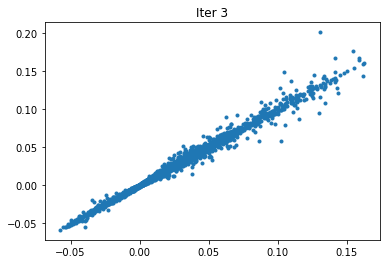

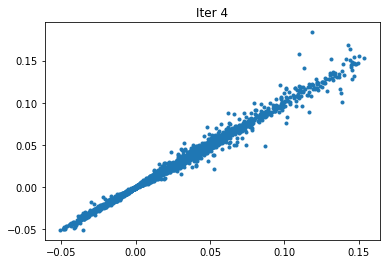

In [83]:
tt1 = []
#case for kinda high variabiity with very high Ion/Ioff ration(ideal Ion/Ioff ratio)
for i in range(1):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,2, lrBP, lrNP, step, mu, 0.001, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt1.append(trainAccVar)

In [ ]:
iter=1
lrBP=1
lrNP=1
pert=0.01
mu = 0.7
sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001]
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

trainAcc1 = []
valAcc1 = []
trainLoss1 = []
valLoss1 = []
sW1 = []
for i in range(len(sigma)):
    train_acc, val_acc, train_loss, val_loss, sum_weights = batchGDCompOCUp(x_train,y_train,5, lrBP, lrNP, pert = step, mu = mu, sigma = sigma[i], vDD = vDD, precision = precision, step=step, discreteSteps = discreteSteps, wRange = wRange, print_op=1)
    trainAcc1.append(train_acc)
    valAcc1.append(val_acc)
    trainLoss1.append(train_loss)
    valLoss1.append(val_loss)
    sW1.append(sum_weights)
    print(f"--Done{i}")

Params Initialised
1.0000000000000004
Iteration: 1::Train accuracy: 85.062::Val accuracy: 82.071:#########################:Train Acc BP::86.93 Val Acc BP::87.143
0.9715827856638329
Iteration: 2::Train accuracy: 89.844::Val accuracy: 87.371:#########################:Train Acc BP::90.938 Val Acc BP::89.886
0.9554054152334497
Iteration: 3::Train accuracy: 91.571::Val accuracy: 83.814:#########################:Train Acc BP::92.535 Val Acc BP::90.6
0.9472570973414198
Iteration: 4::Train accuracy: 92.29::Val accuracy: 86.457:#########################:Train Acc BP::93.281 Val Acc BP::91.043
0.939294204211808
Iteration: 5::Train accuracy: 92.695::Val accuracy: 87.914:#########################:Train Acc BP::93.835 Val Acc BP::91.314
--Done0
Params Initialised
1.0000000000000004
Iteration: 1::Train accuracy: 88.29::Val accuracy: 88.143:#########################:Train Acc BP::88.367 Val Acc BP::88.329
0.997165351039079
Iteration: 2::Train accuracy: 90.776::Val accuracy: 90.743:###################

In [ ]:
trainAcc1 = [[[86.93015873015874, 85.06190476190476], [90.93809523809524, 89.84444444444445],
  [92.53492063492064, 91.57142857142857],
  [93.28095238095237, 92.29047619047618],
  [93.83492063492064, 92.6952380952381]],
 [[88.36666666666667, 88.29047619047618],
  [91.11746031746031, 90.77619047619048],
  [92.58253968253968, 92.52380952380952],
  [93.33968253968254, 93.11746031746033],
  [93.82698412698413, 93.73015873015873]],
 [[88.68412698412699, 86.18412698412699],
  [91.2047619047619, 91.13015873015873],
  [92.67619047619048, 92.40317460317459],
  [93.41587301587302, 93.07619047619048],
  [93.8968253968254, 93.7952380952381]],
 [[88.61587301587302, 87.34126984126985],
  [91.23174603174603, 91.11587301587302],
  [92.64126984126985, 92.57460317460317],
  [93.4031746031746, 93.31746031746032],
  [93.88253968253967, 93.85396825396826]],
 [[88.64285714285714, 88.10952380952381],
  [91.19047619047619, 91.24285714285715],
  [92.63809523809525, 92.48888888888888],
  [93.37777777777778, 93.07460317460318],
  [93.87460317460318, 93.78253968253968]]]

In [ ]:
trainAccVarBP = [[i[0] for i in trainAccVar]
trainAccVarWP = [i[1] for i in trainAccVar]

In [44]:
plt.figure(figsize = (12, 8))
ll = 0
trainAccVarBP = [i[0] for i in trainAccVar[ll]]
trainAccVarWP = [i[1] for i in trainAccVar[ll]]
plt.plot(trainAccVarWP, 'ro')
plt.plot(trainAccVarBP, 'bx')
plt.plot(trainAccVarWP, alpha = 0.3, c = 'r')
plt.plot(trainAccVarBP, alpha = 0.3, c = 'b')
plt.legend(["WP", "BP"])
plt.title(f"mu = 0.7; sigma = {sigma[ll]}; Ion~10e-06; Ioff~10e-7")

IndexError: invalid index to scalar variable.

<Figure size 864x576 with 0 Axes>

In [ ]:
for i in trainAcc1:
    eachVar = [j[0] for j in i]
    break
eachVar

[86.93015873015874,
 90.93809523809524,
 92.53492063492064,
 93.28095238095237,
 93.83492063492064]

In [ ]:
[i[0] for i in trainAcc1[0]]

[86.93015873015874,
 90.93809523809524,
 92.53492063492064,
 93.28095238095237,
 93.83492063492064]

TypeError: 'float' object is not subscriptable

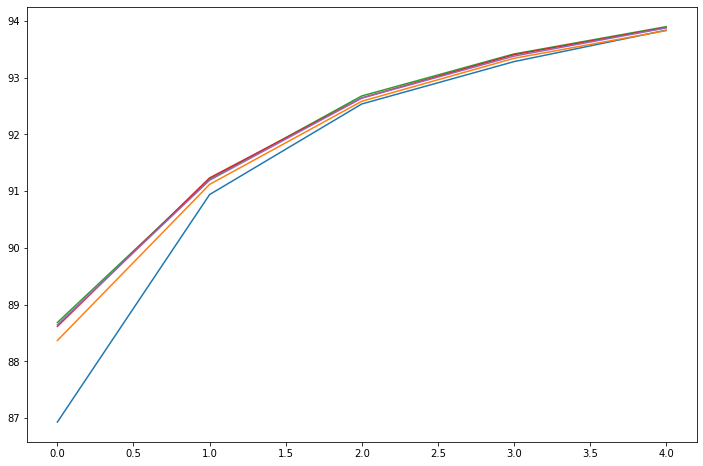

In [ ]:
plt.figure(figsize = (12, 8))
WPAcrossVar = []
for i in trainAcc1:
    eachVar = [j[0] for j in i]
    WPAcrossVar.append(eachVar)
for i in WPAcrossVar:
    plt.plot(i)
plt.legend([f"Sigma = {sigma[0]}", f"Sigma = {sigma[1]}", f"Sigma = {sigma[2]}", f"Sigma = {sigma[3]}", f"Sigma = {sigma[4]}"])
plt.title("WP for different variabiity in Ion, Ioff~1e-07")

Text(0.5, 1.0, 'BP for different variabiity in Ion, Ioff~1e-07')

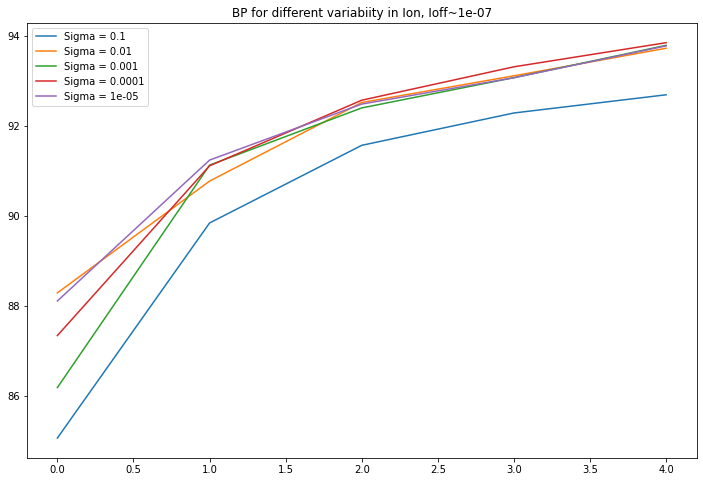

In [ ]:
plt.figure(figsize = (12, 8))
WPAcrossVar = []
for i in trainAcc1:
    eachVar = [j[1] for j in i]
    WPAcrossVar.append(eachVar)
for i in WPAcrossVar:
    plt.plot(i)
plt.legend([f"Sigma = {sigma[0]}", f"Sigma = {sigma[1]}", f"Sigma = {sigma[2]}", f"Sigma = {sigma[3]}", f"Sigma = {sigma[4]}"])
plt.title("BP for different variabiity in Ion, Ioff~1e-07")

## Quantization versus variability in the case of WP

In [30]:
def batchGDCompOCUp(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init_seeded(seed=2)

  W1quantwp, b1quantwp, W2quantwp, b2quantwp= W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()
#   W1quantwp = roundArbitrary(W1quantwp, step, wRange)#weights have to maintained as their digitized versions
#   b1quantwp = roundArbitrary(b1quantwp, step, wRange)
#   W2quantwp = roundArbitrary(W2quantwp, step, wRange)
#   b2quantwp = roundArbitrary(b2quantwp, step, wRange)
  

  W1wp, b1wp, W2wp, b2wp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()
  W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
  b1wp = roundArbitrary(b1wp, step, wRange)
  W2wp = roundArbitrary(W2wp, step, wRange)
  b2wp = roundArbitrary(b2wp, step, wRange)


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, k =10000000)#k = Ion/Ioff
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, k =10000000)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, k =10000000)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =10000000)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    # w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    # b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    # w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    # b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    # w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    # b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    #print(cosine_similarity(W1quantwp.reshape(1,-1), W1wp.reshape(1,-1))[0][0])
    for j in range(2): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      
      W1varocwp = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      b1varocwp = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      W2varocwp = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      b2varocwp = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)
      

      #W1comp.append([W1np[0, 0], W1varocwp[0, 0]])
      plt.figure()
      plt.subplot(121)
      plt.plot(W1quantwp.flatten(), W1wp.flatten(), '.')
      plt.subplot(122)
      plt.plot(W1wp.flatten(), W1varocwp.flatten(), '.')
      #print(W1varocwp)
      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"WP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)
      lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))


      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      #dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varocnp, W2varocnp, W3varocnp,b1varocnp, b2varocnp, b3varocnp, X1, Y1)
      #print(f"iter in iter{j}")
      #dW1wp, db1wp, dW2wp, db2wp = WP(W1varocwp, b1varocwp, W2varocwp, b2varocwp, pert, lossBeforePert, X1, Y1)
      dW1wp, db1wp, dW2wp, db2wp = WPwithVarUp(W1wp, b1wp, W2wp, b2wp, pert, lossBeforePert, X1, Y1, precision, step, discreteSteps,  wRange, W1varocwp, b1varocwp, W2varocwp, b2varocwp, W1Currents, b1Currents, W2Currents, b2Currents)
      #print(dW1wp)
      #print(W1roundwp/step)

      dW1roundwp = roundArbitrary(dW1wp, step, wRange)#weights have to maintained as their digitized versions
      db1roundwp = roundArbitrary(db1wp, step, wRange)
      dW2roundwp = roundArbitrary(dW2wp, step, wRange)
      db2roundwp = roundArbitrary(db2wp, step, wRange)
      



      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1roundwp, db1roundwp, dW2roundwp, db2roundwp, lr = lrNP)
      W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
      b1wp = roundArbitrary(b1wp, step, wRange)
      W2wp = roundArbitrary(W2wp, step, wRange)
      b2wp = roundArbitrary(b2wp, step, wRange)
      #print(dW1wp/step)
      #print(W1wp)
      ###print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)




      #doing the back propagation for the same data set sample

      Z1, A1, Z2, A2 = forward(X1, W1quantwp, b1quantwp, W2quantwp, b2quantwp) 
      print(f"                                                                   wPQuant Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      dW1quantwp, db1quantwp, dW2quantwp, db2quantwp = WP(W1quantwp, b1quantwp, W2quantwp, b2quantwp, pert=pert, lossBeforePert=loss, X=X1, y=Y1)



    #   dW1quantround = roundArbitrary(dW1quantwp, step, wRange)#weights have to maintained as their digitized versions
    #   db1quantround = roundArbitrary(db1quantwp, step, wRange)
    #   dW2quantround = roundArbitrary(dW2quantwp, step, wRange)
    #   db2quantround = roundArbitrary(db2quantwp, step, wRange)


      W1quantwp, b1quantwp, W2quantwp, b2quantwp = param_update(W1quantwp, b1quantwp, W2quantwp, b2quantwp,  dW1quantwp,  db1quantwp, dW2quantwp, db2quantwp,  lr = lrNP)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()
    #   plt.figure()
    #   plt.plot(dW1wp.flatten(), dW1quantwp.flatten(), '.')
    #   plt.xlim([-0.4, 0.4])
    #   plt.ylim([-0.4, 0.4])
    #   plt.title(f"Iter {j}")
      #plt.plot(dW1roundbp.flatten(), dW1roundwp.flatten(), '.', alpha = 0.3)
    #   plt.figure()
    #   plt.plot(dW1wp.flatten(), dW1roundwp.flatten(), '.')


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      # plt.figure()
      # plt.plot(W1bp.flatten())
      # plt.plot(W1wp.flatten())
      # plt.legend(["BP", "Wp"])
      _, _, _, A2_train = forward(X, weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange))
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1quantwp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1quantwp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2quantwp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2quantwp, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):

       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([accuracy(predictions(A2_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_val_bp = forward(x_val, W1quantwp, b1quantwp, W2quantwp, b2quantwp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([accuracy(predictions(A2_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [156]:
iter=1
lrBP=1
lrNP=1
pert=0.01
mu = 0.7
sigma = 0.001
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 2
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

In [166]:
tt1 = []
#case for kinda high variabiity with very high Ion/Ioff ration(ideal Ion/Ioff ratio)
for i in range(1):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,1, lrBP, lrNP, step, mu, 0.0001, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt1.append(trainAccVar)

Params Initialised
Iteration: 1::Train accuracy: 16.302::Val accuracy: 16.629:#########################:Train Acc BP::16.387 Val Acc BP::16.843


Params Initialised
Iteration: 1::Train accuracy: 20.343::Val accuracy: 19.914:#########################:Train Acc BP::20.229 Val Acc BP::19.686


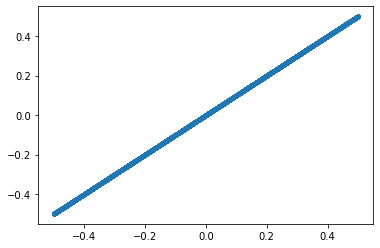

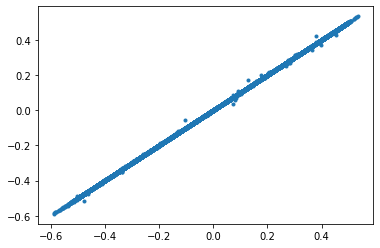

In [164]:
tt1 = []
#case for kinda high variabiity with very high Ion/Ioff ration(ideal Ion/Ioff ratio)
for i in range(1):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,1, lrBP, lrNP, step, mu, 0.0001, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt1.append(trainAccVar)

Params Initialised
Iteration: 1::Train accuracy: 22.732::Val accuracy: 22.8:#########################:Train Acc BP::22.443 Val Acc BP::22.514


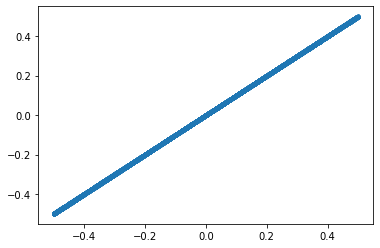

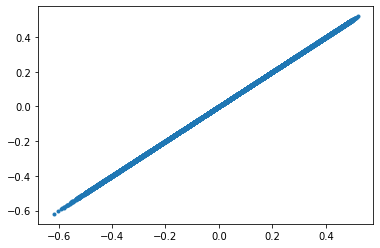

In [161]:
tt1 = []
#case for kinda high variabiity with very high Ion/Ioff ration(ideal Ion/Ioff ratio)
for i in range(1):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,1, lrBP, lrNP, step, mu, 0.0001, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt1.append(trainAccVar)

Params Initialised
Iteration: 1::Train accuracy: 25.832::Val accuracy: 26.4:#########################:Train Acc BP::26.086 Val Acc BP::26.314


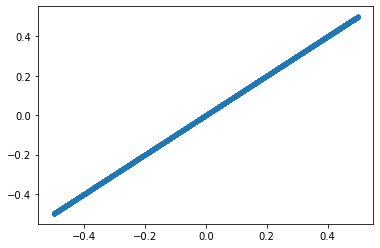

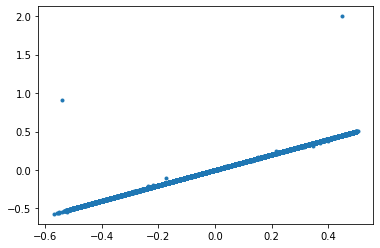

In [158]:
tt1 = []
#case for kinda high variabiity with very high Ion/Ioff ration(ideal Ion/Ioff ratio)
for i in range(1):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,1, lrBP, lrNP, step, mu, 0.0001, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt1.append(trainAccVar)

Params Initialised
Iteration: 1::Train accuracy: 31.76::Val accuracy: 31.543:#########################:Train Acc BP::33.794 Val Acc BP::33.357


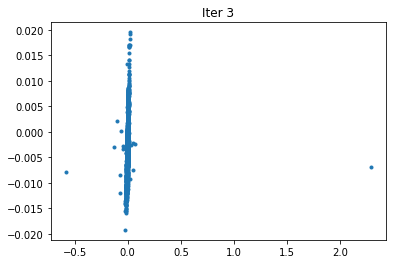

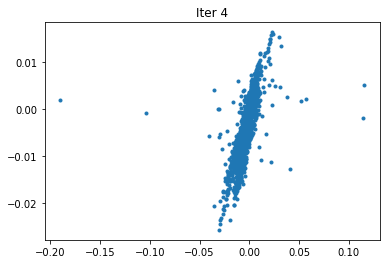

In [105]:
tt1 = []
#case for kinda high variabiity with very high Ion/Ioff ration(ideal Ion/Ioff ratio)
for i in range(1):
    trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,1, lrBP, lrNP, step, mu, 0.001, vDD, precision, step, discreteSteps, wRange, print_op=1)
    tt1.append(trainAccVar)

##
1. check dw ideal (bp) with dw of ideal parameters with nonidealities present
2. to test that uantization on/off ration and variabilti has been implemented correctly - plot W(non ideal) vs W(ideal) for the first iteration 
non ideal can be any of the abvoe and the others significnlty lesser
3. choose different sigma and no of bits - draw surfaces quantization vs sigma for  bp and wp

In [31]:
iter=1
lrBP=0.1
lrNP=0.1
pert=0.1
mu = 0.7
sigma = 0.01
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 2
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

In [30]:
def batchGDCompOCUp(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init_seeded(seed=2)

  W1bp, b1bp, W2bp, b2bp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  

  W1bpvar, b1bpvar, W2bpvar, b2bpvar = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
  b1bpvar = roundArbitrary(b1bpvar, step, wRange)
  W2bpvar = roundArbitrary(W2bpvar, step, wRange)
  b2bpvar = roundArbitrary(b2bpvar, step, wRange)


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      

      
      W1varocwp = weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange)
      b1varocwp = weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange)
      W2varocwp = weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange)
      b2varocwp = weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange)

      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"BP with Var Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))


      dW1bpvar, db1bpvar, dW2bpvar, db2bpvar = backprop(Z1, A1, Z2, A2, W1varocwp, W2varocwp, X1, Y1)
      #print(dW1wp)
      #print(W1roundwp/step)

      dW1roundbpvar = roundArbitrary(dW1bpvar, step, wRange)#weights have to maintained as their digitized versions
      db1roundbpvar = roundArbitrary(db1bpvar, step, wRange)
      dW2roundbpvar = roundArbitrary(dW2bpvar, step, wRange)
      db2roundbpvar = roundArbitrary(db2bpvar, step, wRange)
      



      W1bpvar, b1bpvar, W2bpvar, b2bpvar = param_update(W1bpvar, b1bpvar, W2bpvar,b2bpvar, dW1roundbpvar, db1roundbpvar, dW2roundbpvar, db2roundbpvar, lr = lrNP)
      W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
      b1bpvar = roundArbitrary(b1bpvar, step, wRange)
      W2bpvar = roundArbitrary(W2bpvar, step, wRange)
      b2bpvar = roundArbitrary(b2bpvar, step, wRange)


      #doing the back propagation for the same data set sample

    #   Z1, A1, Z2, A2 = forward(X1, W1bp, b1bp, W2bp, b2bp) 
    #   print(f"                                                                   BP(Software) Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

    #   #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
    #   #loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
    #   #dW1quantwp, db1quantwp, dW2quantwp, db2quantwp = WP(W1quantwp, b1quantwp, W2quantwp, b2quantwp, pert=pert, lossBeforePert=loss, X=X1, y=Y1)
    #   dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1bp, W2bp, X1, Y1)



    # #   dW1quantround = roundArbitrary(dW1quantwp, step, wRange)#weights have to maintained as their digitized versions
    # #   db1quantround = roundArbitrary(db1quantwp, step, wRange)
    # #   dW2quantround = roundArbitrary(dW2quantwp, step, wRange)
    # #   db2quantround = roundArbitrary(db2quantwp, step, wRange)


    #   W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp,  dW1bp,  db1bp, dW2bp, db2bp,  lr = lrNP)
      # if j==0 or j==1:
      #   plt.figure(figsize=(16, 8))
      #   plt.suptitle(f"Intial model plots at iter = {i} epcoch {j}")
      #   plt.subplot(121)
      #   plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
      #   plt.xlim([-1, 1])
      #   plt.ylim([-1, 1])
      #   plt.title(f"W1 prec = {precision} sig = {sigma}  rat = {onoff}")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
      #   plt.subplot(122)
      #   plt.plot(dW1bp.flatten(), dW1bpvar.flatten(), '.')
      #   plt.xlim([-0.05, 0.05])
      #   plt.ylim([-0.05, 0.05])
      #   plt.title(f"dW1 prec = {precision} sig = {sigma}  rat = {onoff}")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
    

    # if i==iter-1:

    #   plt.figure(figsize=(16, 8))
    #   plt.suptitle("Final trained model plots")
    #   plt.subplot(121)
    #   plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
    #   plt.xlim([-1, 1])
    #   plt.ylim([-1, 1])
    #   plt.title(f"W1 prec = {precision} sig = {sigma}  rat = {onoff}")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")
    #   plt.subplot(122)
    #   plt.plot(dW1bp.flatten(), dW1bpvar.flatten(), '.')
    #   plt.xlim([-0.05, 0.05])
    #   plt.ylim([-0.05, 0.05])
    #   plt.title(f"dW1 prec = {precision} sig = {sigma}  rat = {onoff}")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")



    if (i+1)%(print_op) == 0:

      _, _, _, A2_train = forward(X, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):

       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([train_score, accuracy(predictions(A2_train_bp), Y)])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_val_bp = forward(x_val,weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([ val_score, accuracy(predictions(A2_val_bp), y_val)])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy(software BP): {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP var::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP var::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [160]:
prec = [4, 8, 16, 32]
Sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
nf = [10, 100, 1000, 10000, 100000]
trainAccSoft, trainAccVari, valAccSoft, valAccVari = np.zeros((len(prec), len(Sigma), len(nf))), np.zeros((len(prec), len(Sigma), len(nf))), np.zeros((len(prec), len(Sigma), len(nf))), np.zeros((len(prec), len(Sigma), len(nf)))
for i in range(len(prec)):
    for j in range(len(Sigma)):
        for k in range(len(nf)):
            print(f"Training for prec = {prec[i]} sig = {Sigma[j]} onoff = {nf[k]}")
            trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,10, lrBP, lrNP, step, mu, Sigma[j], vDD, prec[i], step, discreteSteps, wRange, onoff = nf[k],print_op=1)
            trainAccSoft[i, j, k] = trainAccVar[-1][0]
            trainAccVari[i, j, k] = trainAccVar[-1][1]
            valAccSoft[i, j, k] = valAccVar[-1][0]
            valAccVari[i, j, k] = valAccVar[-1][1]

Training for prec = 4 sig = 0.1 onoff = 10
Params Initialised
Iteration: 1::Train accuracy(software BP): 74.067::Val accuracy: 74.043:#########################:Train Acc BP var::10.427 Val Acc BP var::10.343
Iteration: 2::Train accuracy(software BP): 81.433::Val accuracy: 81.6:#########################:Train Acc BP var::10.025 Val Acc BP var::9.629
Iteration: 3::Train accuracy(software BP): 84.468::Val accuracy: 84.629:#########################:Train Acc BP var::10.025 Val Acc BP var::9.629
Iteration: 4::Train accuracy(software BP): 86.275::Val accuracy: 86.243:#########################:Train Acc BP var::10.425 Val Acc BP var::10.343
Iteration: 5::Train accuracy(software BP): 87.454::Val accuracy: 87.2:#########################:Train Acc BP var::10.427 Val Acc BP var::10.343
Iteration: 6::Train accuracy(software BP): 88.321::Val accuracy: 88.1:#########################:Train Acc BP var::10.427 Val Acc BP var::10.343
Iteration: 7::Train accuracy(software BP): 88.951::Val accuracy: 88.7:

KeyboardInterrupt: 

In [305]:
l = np.arange(0, 100001, 5000)
l[0] = 10
l

array([    10,   5000,  10000,  15000,  20000,  25000,  30000,  35000,
        40000,  45000,  50000,  55000,  60000,  65000,  70000,  75000,
        80000,  85000,  90000,  95000, 100000])

In [27]:
#Sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
#nf = [10, 100, 1000, 10000, 100000]
nf = np.arange(0, 100001, 5000)
nf[0] = 10
trainAccSoft, trainAccVari, valAccSoft, valAccVari = np.zeros((len(Sigma), len(nf))), np.zeros((len(Sigma), len(nf))), np.zeros((len(Sigma), len(nf))), np.zeros((len(Sigma), len(nf)))
for j in range(len(Sigma)):
    for k in range(len(nf)):
        print(f"Training for sig = {Sigma[j]} onoff = {nf[k]}")
        trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,5, lrBP, lrNP, step, mu, Sigma[j], vDD, 16, step, discreteSteps, wRange, onoff = nf[k],print_op=1)
        trainAccSoft[j, k] = trainAccVar[-1][0]
        trainAccVari[j, k] = trainAccVar[-1][1]
        valAccSoft[j, k] = valAccVar[-1][0]
        valAccVari[j, k] = valAccVar[-1][1]

Training for sig = 0.1 onoff = 10
Params Initialised
Iteration: 1::Train accuracy(software BP): 74.067::Val accuracy: 74.043:#########################:Train Acc BP var::18.248 Val Acc BP var::18.5
Iteration: 2::Train accuracy(software BP): 81.433::Val accuracy: 81.6:#########################:Train Acc BP var::29.629 Val Acc BP var::28.986
Iteration: 3::Train accuracy(software BP): 84.468::Val accuracy: 84.629:#########################:Train Acc BP var::26.635 Val Acc BP var::26.786
Iteration: 4::Train accuracy(software BP): 86.275::Val accuracy: 86.243:#########################:Train Acc BP var::31.805 Val Acc BP var::31.657
Iteration: 5::Train accuracy(software BP): 87.454::Val accuracy: 87.2:#########################:Train Acc BP var::30.319 Val Acc BP var::30.043
Training for sig = 0.1 onoff = 5000
Params Initialised
Iteration: 1::Train accuracy(software BP): 74.067::Val accuracy: 74.043:#########################:Train Acc BP var::26.486 Val Acc BP var::27.486
Iteration: 2::Train ac

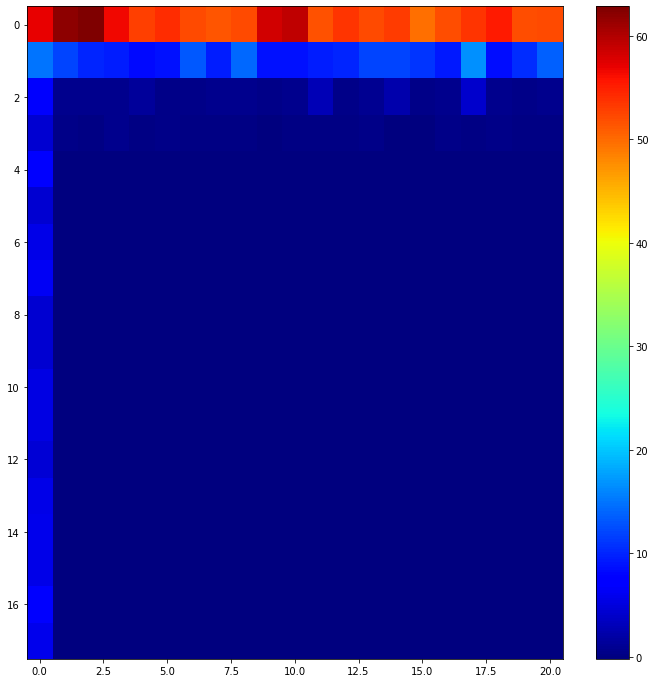

In [37]:
Sigma = 10**(-np.arange(1, 7, 0.35))
#nf = [10, 100, 1000, 10000, 100000]
nf = np.arange(0, 100001, 5000)
nf[0] = 10
plt.figure(figsize = (12, 12))
# plt.suptitle("Plot of final accuracies for different variability and Ion/Ioff ratio")
# plt.subplot(441)
im = plt.imshow(87.454-np.array(trainAccVari), cmap = 'jet', aspect ='auto', interpolation='nearest')
plt.colorbar(im)
#plt.xticks(np.arange(1, 7, 0.35))
#plt.yticks(nf)
plt.show()

In [29]:
trainAccVari = np.array([[30.31904762, 25.49365079, 24.61746032, 30.79206349, 34.67142857,
        33.32222222, 35.20634921, 36.05555556, 35.37619048, 29.12539683,
        28.11746032, 35.77460317, 33.93650794, 35.36190476, 34.27619048,
        37.6984127 , 35.45396825, 33.79047619, 32.09365079, 35.55714286,
        35.38888889],
       [72.38730159, 75.49047619, 77.34920635, 77.96349206, 79.22222222,
        78.76190476, 74.2       , 78.01111111, 73.31746032, 78.73492063,
        78.73333333, 77.8968254 , 77.53333333, 75.56190476, 75.40634921,
        76.56507937, 78.23174603, 70.66349206, 78.87142857, 76.9       ,
        73.67460317],
       [80.63650794, 86.87936508, 86.78412698, 86.84444444, 86.0015873 ,
        87.11269841, 86.94126984, 86.78730159, 86.73492063, 86.92063492,
        86.7968254 , 84.55555556, 87.13015873, 86.54603175, 84.94761905,
        86.95714286, 86.7984127 , 83.34920635, 86.82539683, 87.12380952,
        86.85873016],
       [83.        , 86.94126984, 87.17619048, 86.83333333, 87.2968254 ,
        87.08571429, 87.22857143, 87.15714286, 87.36031746, 87.56190476,
        87.38412698, 87.30634921, 87.17777778, 86.91269841, 87.42222222,
        87.4       , 86.99047619, 87.38412698, 87.03492063, 87.36825397,
        87.28412698],
       [80.22857143, 87.62857143, 87.61269841, 87.6031746 , 87.63492063,
        87.63333333, 87.63650794, 87.61428571, 87.58730159, 87.6031746 ,
        87.63174603, 87.62857143, 87.63968254, 87.64603175, 87.62698413,
        87.5968254 , 87.63492063, 87.63809524, 87.63650794, 87.63174603,
        87.63492063],
       [82.96825397, 87.43650794, 87.43650794, 87.43650794, 87.43650794,
        87.42539683, 87.43333333, 87.42857143, 87.43015873, 87.43333333,
        87.42222222, 87.43333333, 87.41746032, 87.43174603, 87.43333333,
        87.43492063, 87.43492063, 87.42857143, 87.42698413, 87.43968254,
        87.42539683],
       [81.93650794, 87.42698413, 87.42857143, 87.42380952, 87.42380952,
        87.43492063, 87.42698413, 87.42857143, 87.42857143, 87.42698413,
        87.43015873, 87.43174603, 87.43333333, 87.43174603, 87.42380952,
        87.43174603, 87.42698413, 87.43015873, 87.43015873, 87.42698413,
        87.43015873],
       [81.17460317, 87.45079365, 87.44920635, 87.45396825, 87.44285714,
        87.45079365, 87.45238095, 87.45238095, 87.44761905, 87.44761905,
        87.44444444, 87.45238095, 87.44444444, 87.44920635, 87.44444444,
        87.45079365, 87.45396825, 87.45238095, 87.44761905, 87.44444444,
        87.44761905],
       [82.97142857, 87.44603175, 87.46031746, 87.45238095, 87.45555556,
        87.45714286, 87.45873016, 87.46349206, 87.45873016, 87.45555556,
        87.45714286, 87.45396825, 87.45714286, 87.45714286, 87.45555556,
        87.45396825, 87.45555556, 87.45873016, 87.45238095, 87.45396825,
        87.45555556],
       [83.05873016, 87.44761905, 87.45079365, 87.46190476, 87.46031746,
        87.45873016, 87.44920635, 87.45555556, 87.45714286, 87.45079365,
        87.45238095, 87.45238095, 87.46031746, 87.45396825, 87.45238095,
        87.45079365, 87.45238095, 87.45238095, 87.45396825, 87.44920635,
        87.45238095],
       [82.06666667, 87.43809524, 87.45079365, 87.44444444, 87.44285714,
        87.44285714, 87.44920635, 87.45714286, 87.44444444, 87.44603175,
        87.44920635, 87.44920635, 87.44603175, 87.44285714, 87.45079365,
        87.44920635, 87.44920635, 87.45714286, 87.45555556, 87.45714286,
        87.45396825],
       [82.12380952, 87.44126984, 87.45238095, 87.45079365, 87.43809524,
        87.44444444, 87.44444444, 87.45238095, 87.44761905, 87.44920635,
        87.45079365, 87.44285714, 87.44285714, 87.44920635, 87.45079365,
        87.44285714, 87.44761905, 87.45396825, 87.45555556, 87.45714286,
        87.45555556],
       [82.75396825, 87.44603175, 87.44920635, 87.44920635, 87.43809524,
        87.43968254, 87.44761905, 87.45396825, 87.44761905, 87.43968254,
        87.44126984, 87.44126984, 87.45396825, 87.44285714, 87.44761905,
        87.44603175, 87.44285714, 87.44444444, 87.44444444, 87.44444444,
        87.44444444],
       [81.78888889, 87.44603175, 87.43968254, 87.44920635, 87.44126984,
        87.44603175, 87.44444444, 87.44126984, 87.44126984, 87.45396825,
        87.44126984, 87.44285714, 87.44920635, 87.44603175, 87.44285714,
        87.44285714, 87.44285714, 87.44603175, 87.44761905, 87.44285714,
        87.44920635],
       [81.54126984, 87.44761905, 87.44285714, 87.45555556, 87.46349206,
        87.44603175, 87.45555556, 87.45873016, 87.44761905, 87.44603175,
        87.44603175, 87.45079365, 87.44920635, 87.44444444, 87.44920635,
        87.44444444, 87.44920635, 87.44444444, 87.44761905, 87.44126984,
        87.45079365],
       [81.9047619 , 87.44126984, 87.43968254, 87.45238095, 87.45396825,
        87.43809524, 87.44603175, 87.45714286, 87.44285714, 87.44920635,
        87.43968254, 87.45079365, 87.44126984, 87.44126984, 87.44761905,
        87.44126984, 87.43968254, 87.44285714, 87.45238095, 87.44603175,
        87.44285714],
       [80.42380952, 87.43650794, 87.43650794, 87.45396825, 87.45079365,
        87.44285714, 87.45714286, 87.46031746, 87.45714286, 87.45714286,
        87.44444444, 87.44126984, 87.44444444, 87.44444444, 87.44761905,
        87.44761905, 87.44603175, 87.44761905, 87.45079365, 87.45079365,
        87.44761905],
       [81.69206349, 87.44285714, 87.43492063, 87.45714286, 87.45873016,
        87.44603175, 87.46031746, 87.45714286, 87.46031746, 87.45079365,
        87.44761905, 87.44126984, 87.44285714, 87.44920635, 87.44603175,
        87.44603175, 87.45079365, 87.45238095, 87.44285714, 87.44761905,
        87.44603175]])

In [27]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, fraction=0.045, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<Figure size 864x864 with 0 Axes>

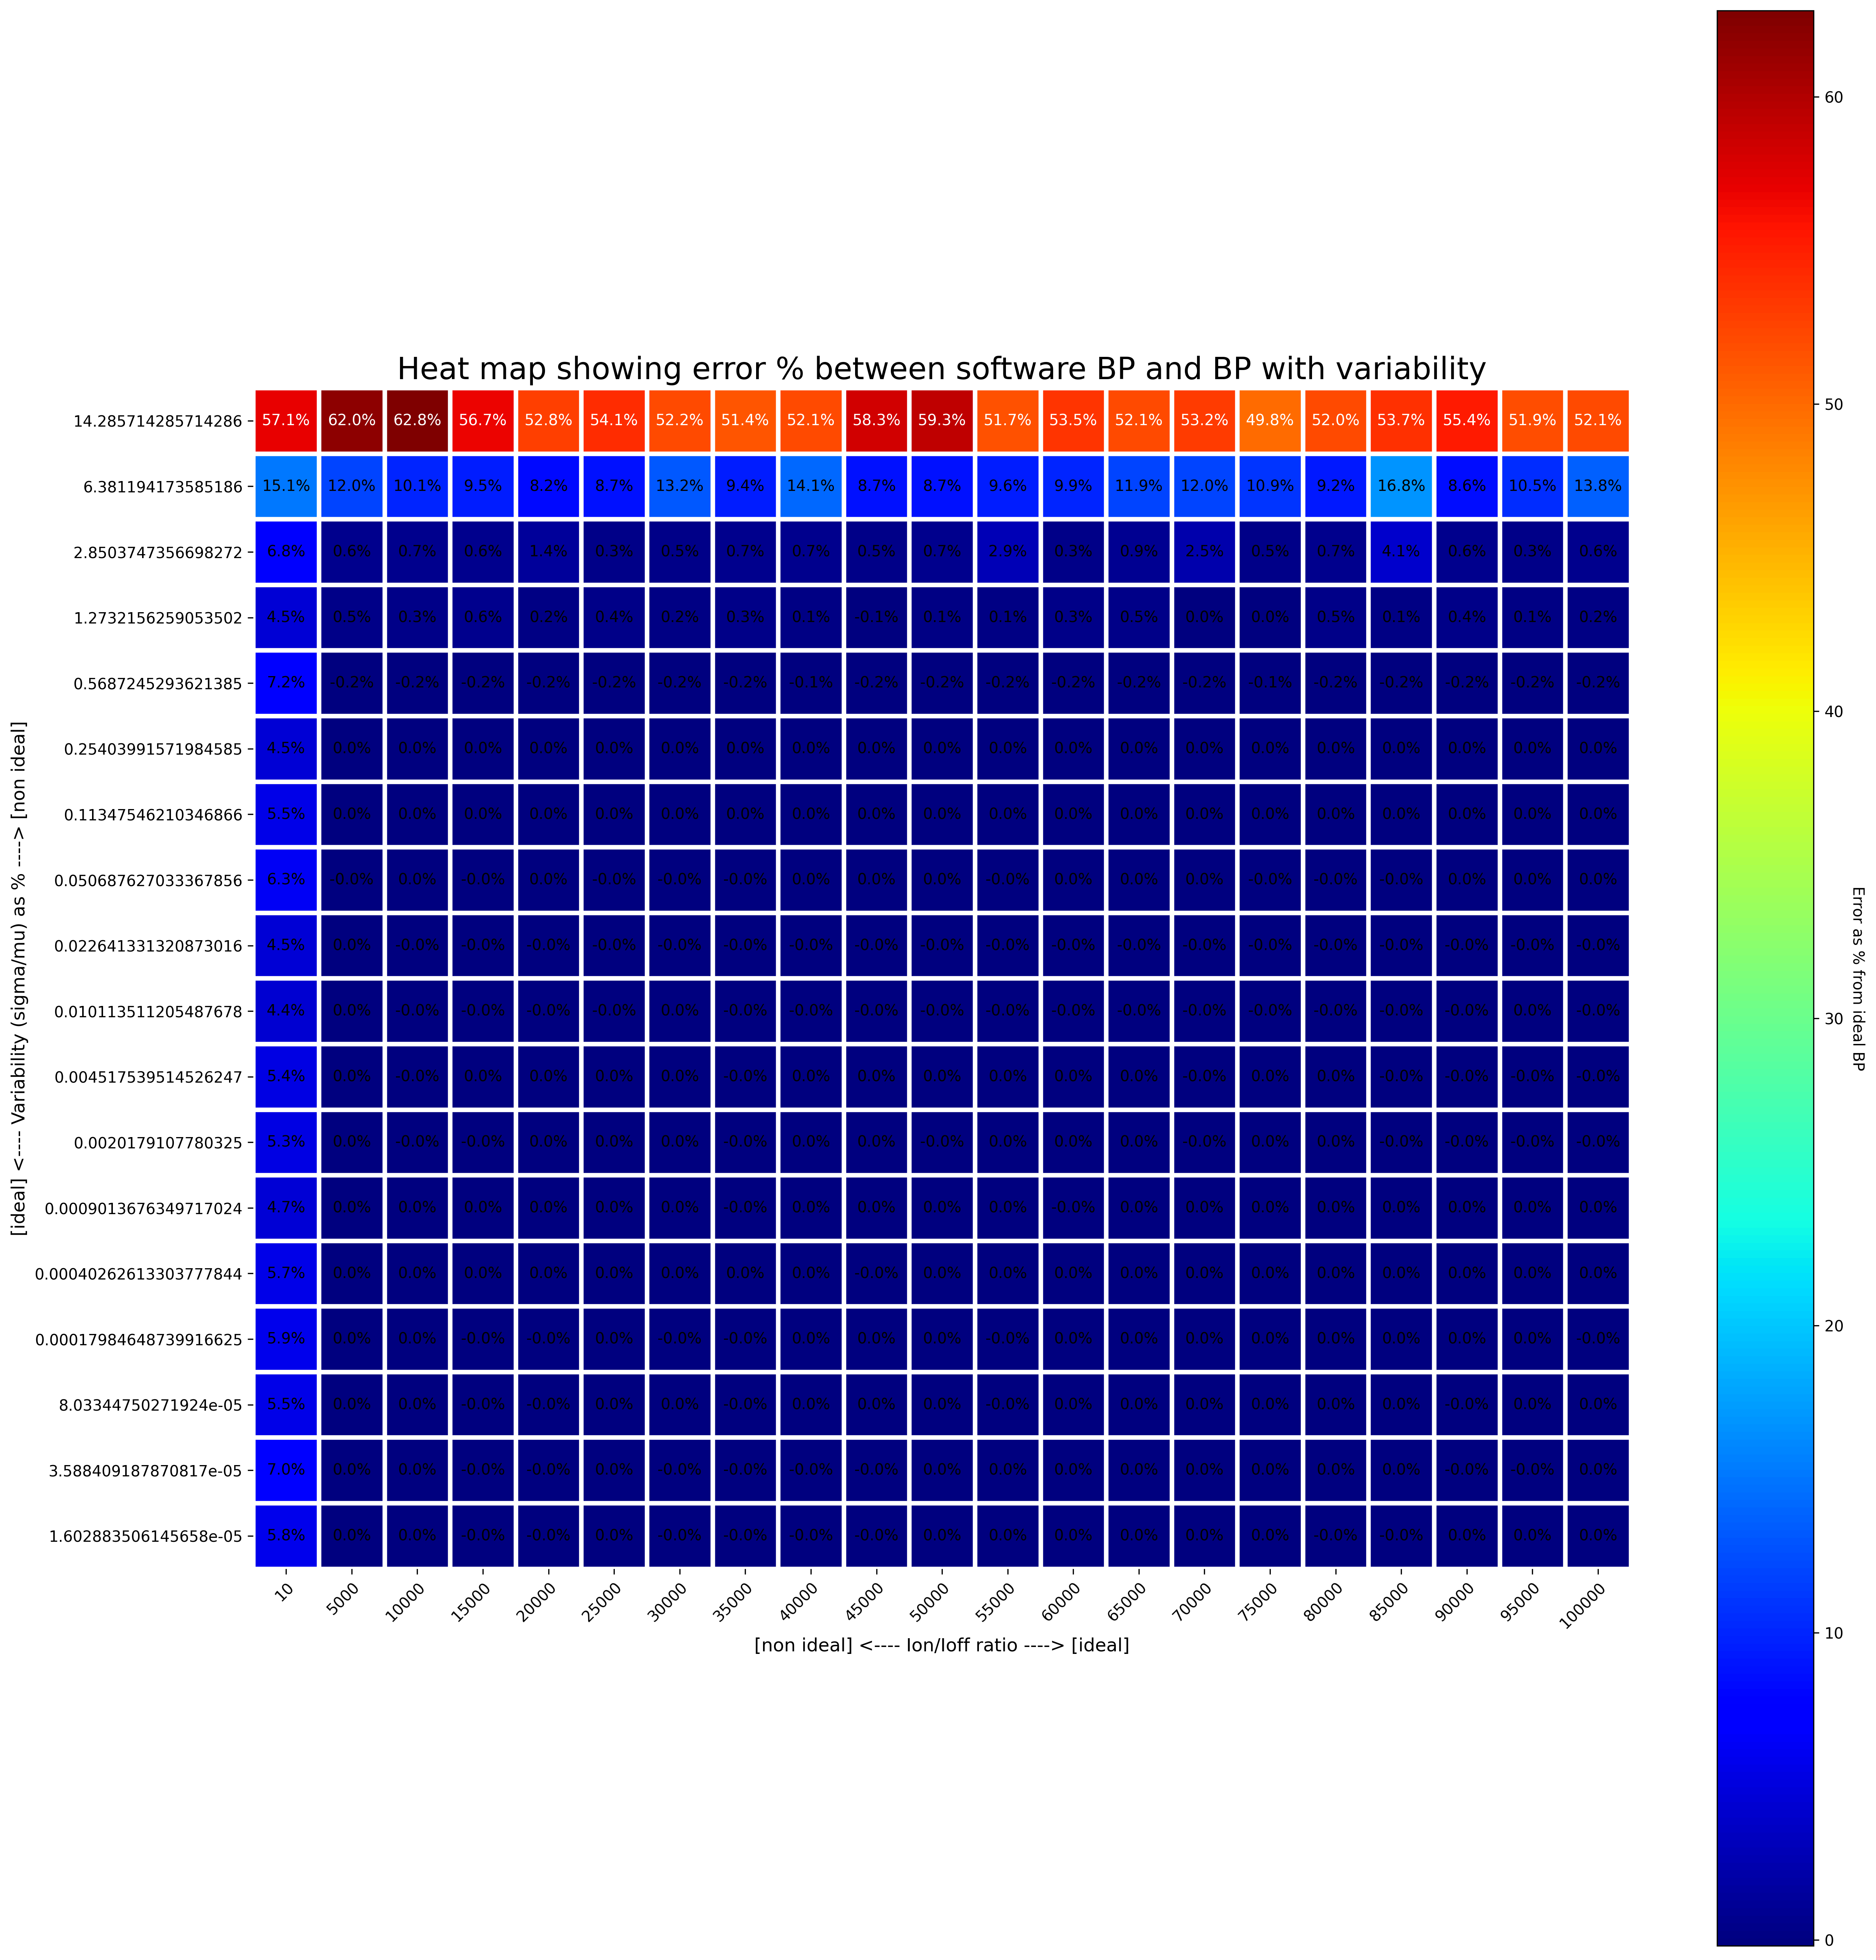

In [67]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(18, 18))

im, cbar = heatmap(np.round(87.45 - trainAccVari, 1), (Sigma*100)/0.7, nf, ax=ax,
                   cmap="jet", cbarlabel="Error as % from ideal BP")
texts = annotate_heatmap(im, valfmt="{x:.1f}%")

fig.tight_layout()
plt.xlabel("[non ideal] <---- Ion/Ioff ratio ----> [ideal]", fontsize=12)
plt.ylabel("[ideal] <---- Variability (sigma/mu) as % ----> [non ideal]", fontsize=12)
plt.title("Heat map showing error % between software BP and BP with variability", fontsize=20)
plt.gcf().set_dpi(300)
plt.show()

In [31]:
import time
#Sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
#nf = [10, 100, 1000, 10000, 100000]
prec = np.array([2,4,6,7, 8,9, 10, 11,12,14, 16])
trainAccSoft, trainAccVari1, valAccSoft, valAccVari1 = np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec)))
for j in range(len(Sigma)):
    for k in range(len(prec)):
        noOfLevels = 2**prec[k]- 1 #no of levels of quantization
        #step = round(wRange/noOfLevels, precision)
        step =  wRange/noOfLevels#step size of each of the step after quantization
        #discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
        discreteSteps = [step*i for i in range(0, noOfLevels)] 
        print(f"Training for sig = {Sigma[j]} prec = {prec[k]} step= {step}")
        trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,40, lrBP, lrNP, step, mu, Sigma[j], vDD, prec[k], step, discreteSteps, wRange, onoff = 1000000,print_op=1)
        trainAccSoft[j, k] = trainAccVar[-1][0]
        trainAccVari1[j, k] = trainAccVar[-1][1]
        valAccSoft[j, k] = valAccVar[-1][0]
        valAccVari1[j, k] = valAccVar[-1][1]
        time.sleep(5)

Training for sig = 0.07943282347242814 prec = 2 step= 0.6666666666666666
Params Initialised
Iteration: 1::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::17.097 Val Acc BP var::17.343
Iteration: 2::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::17.097 Val Acc BP var::17.343
Iteration: 3::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::17.097 Val Acc BP var::17.343
Iteration: 4::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::17.097 Val Acc BP var::17.343
Iteration: 5::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::17.097 Val Acc BP var::17.343
Iteration: 6::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::17.097 Val Acc BP var::17.343
Iteration: 7::Train accuracy(software BP): 1

In [218]:
batchGDCompOCUp(x_train,y_train,40, lrBP, lrNP, step, mu, 0.001, vDD, 16, step, discreteSteps, wRange, onoff = 1000000,print_op=1)

Params Initialised
Iteration: 1::Train accuracy(software BP): 74.067::Val accuracy: 74.043:#########################:Train Acc BP var::72.365 Val Acc BP var::72.2
Iteration: 2::Train accuracy(software BP): 81.433::Val accuracy: 81.6:#########################:Train Acc BP var::79.706 Val Acc BP var::79.471
Iteration: 3::Train accuracy(software BP): 84.468::Val accuracy: 84.629:#########################:Train Acc BP var::82.559 Val Acc BP var::82.471
Iteration: 4::Train accuracy(software BP): 86.275::Val accuracy: 86.243:#########################:Train Acc BP var::84.192 Val Acc BP var::84.086
Iteration: 5::Train accuracy(software BP): 87.454::Val accuracy: 87.2:#########################:Train Acc BP var::85.186 Val Acc BP var::85.314
Iteration: 6::Train accuracy(software BP): 88.321::Val accuracy: 88.1:#########################:Train Acc BP var::85.981 Val Acc BP var::86.157
Iteration: 7::Train accuracy(software BP): 88.951::Val accuracy: 88.7:#########################:Train Acc BP var:

([[74.06666666666666, 72.36507936507937],
  [81.43333333333334, 79.7063492063492],
  [84.46825396825398, 82.55873015873016],
  [86.27460317460317, 84.1920634920635],
  [87.45396825396826, 85.18571428571428],
  [88.32063492063492, 85.98095238095237],
  [88.95079365079364, 86.57142857142858],
  [89.44603174603175, 86.97142857142856],
  [89.90476190476191, 87.42857142857143],
  [90.27142857142857, 87.76507936507937],
  [90.61111111111111, 88.05555555555556],
  [90.90158730158731, 88.33333333333333],
  [91.13968253968254, 88.55873015873016],
  [91.35714285714286, 88.76031746031747],
  [91.53968253968254, 88.96031746031746],
  [91.73333333333333, 89.09047619047618],
  [91.89206349206349, 89.24444444444445],
  [92.08253968253969, 89.4031746031746],
  [92.23015873015873, 89.53015873015873],
  [92.37301587301587, 89.68888888888888],
  [92.53015873015873, 89.76031746031747],
  [92.67301587301587, 89.85079365079365],
  [92.78095238095239, 89.96349206349207],
  [92.86031746031746, 90.026984126984

In [217]:
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
#nf = [10, 100, 1000, 10000, 100000]
for j in range(len(Sigma)):
    a,b,c = initMosParam((1000, 1000), 0.7, Sigma[j], vDD, 16)
    print(f"Mu = {mu} {np.arange(1, 2, 0.1)[1:][j]} sigma = {Sigma[j]} Mean = {np.mean(a)} std = {np.std(a)} % = {(np.std(a)*100)/np.mean(a)}")

Mu = 0.7 1.1 sigma = 0.07943282347242814 Mean = 0.12772054407930258 std = 0.9762839789462701 % = 764.3907141047633
Mu = 0.7 1.2000000000000002 sigma = 0.0630957344480193 Mean = 0.059417205318267254 std = 0.20894874430811097 % = 351.66370277578784
Mu = 0.7 1.3000000000000003 sigma = 0.0501187233627272 Mean = 0.036584315396161284 std = 0.07486045676371107 % = 204.62445710154256
Mu = 0.7 1.4000000000000004 sigma = 0.03981071705534969 Mean = 0.026999498860196237 std = 0.036565460444160265 % = 135.43014495749236
Mu = 0.7 1.5000000000000004 sigma = 0.031622776601683764 Mean = 0.022267616824023253 std = 0.02146430748110137 % = 96.39247724949516
Mu = 0.7 1.6000000000000005 sigma = 0.02511886431509577 Mean = 0.01972744143874649 std = 0.014143904401120348 % = 71.69659808666538
Mu = 0.7 1.7000000000000006 sigma = 0.019952623149688768 Mean = 0.018273968463575915 std = 0.009990864440037191 % = 54.67265886964404
Mu = 0.7 1.8000000000000007 sigma = 0.01584893192461111 Mean = 0.0174088197679061 std = 

In [1]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(10, 10))

im, cbar = heatmap(np.round(87.454 - trainAccVari1, 1), (Sigma*100)/0.7, prec, ax=ax,
                   cmap="jet", cbarlabel="Error as % from ideal BP")
texts = annotate_heatmap(im, valfmt="{x:.1f}%")

fig.tight_layout()
plt.xlabel("[non ideal] <---- Bit precision ----> [ideal]", fontsize=12)
plt.ylabel("[ideal] <---- Variability (sigma/mu) as % ----> [non ideal]", fontsize=12)
plt.title("Heat map showing error % between software BP and BP with variability", fontsize=20)
plt.gcf().set_dpi(300)
plt.show()

NameError: name 'plt' is not defined

## Node pertubation with full variability

In [88]:
def NP(pert, lossBeforePert, Z1, A1, Z2, A2, W1, W2, b1, b2, X1, Y1):
  #calculating dw3 and db3
  #print(W2[3])
  #first approximate dZ3
  m = Y1.shape[0]
  #print(Z3.shape)
  lossArrayAfterPertZ2 = np.zeros_like(Z2)
  for i in range(Z2.shape[0]):
    Z2pert = Z2.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z2pert[i, :] +=  pert
    A2pert = softmax(Z2pert)
    #lossArrayAfterPertZ3[i, :] += np.sum(np.square(A3pert-one_hot_encoding(Y1)), axis=0)
    lossArrayAfterPertZ2[i, :] += crossEntropy(one_hot_encoding(Y1), A2pert)


  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)



  #calculating the dZ1 and db1
  lossArrayAfterPertZ1 = np.zeros_like(Z1)
  for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert
    A1pert = relu(Z1pert)
    
    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = softmax(Z2pert)
    
    #lossArrayAfterPertZ1[i,:] += np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)
    lossArrayAfterPertZ1[i, :] += crossEntropy(one_hot_encoding(Y1), A2pert)

    
  #print(lossArrayAfterPertZ1)
  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

  dW1 = 1/m*np.matmul(dZ1,X1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

  return dW1, db1, dW2, db2

In [203]:
def batchGDCompOCNP(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init_seeded(seed=2)

  W1bp, b1bp, W2bp, b2bp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  

  W1bpvar, b1bpvar, W2bpvar, b2bpvar = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
  b1bpvar = roundArbitrary(b1bpvar, step, wRange)
  W2bpvar = roundArbitrary(W2bpvar, step, wRange)
  b2bpvar = roundArbitrary(b2bpvar, step, wRange)


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      

      
      W1varocwp = weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange)
      b1varocwp = weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange)
      W2varocwp = weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange)
      b2varocwp = weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange)

      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"BP with Var Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      lossBeforePert = crossEntropy(one_hot_encoding(Y1), A2)


      dW1bpvar, db1bpvar, dW2bpvar, db2bpvar = NP(pert, lossBeforePert, Z1, A1, Z2, A2, W1varocwp, W2varocwp, b1varocwp, b2varocwp, X1, Y1)
      #print(dW1wp)
      #print(W1roundwp/step)

      dW1roundbpvar = roundArbitrary(dW1bpvar, step, wRange)#weights have to maintained as their digitized versions
      db1roundbpvar = roundArbitrary(db1bpvar, step, wRange)
      dW2roundbpvar = roundArbitrary(dW2bpvar, step, wRange)
      db2roundbpvar = roundArbitrary(db2bpvar, step, wRange)
      



      W1bpvar, b1bpvar, W2bpvar, b2bpvar = param_update(W1bpvar, b1bpvar, W2bpvar,b2bpvar, dW1roundbpvar, db1roundbpvar, dW2roundbpvar, db2roundbpvar, lr = lrNP)
      W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
      b1bpvar = roundArbitrary(b1bpvar, step, wRange)
      W2bpvar = roundArbitrary(W2bpvar, step, wRange)
      b2bpvar = roundArbitrary(b2bpvar, step, wRange)


      #doing the back propagation for the same data set sample

    #   Z1, A1, Z2, A2 = forward(X1, W1bp, b1bp, W2bp, b2bp) 
    #   print(f"                                                                   BP(Software) Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

    #   #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
    #   loss = crossEntropy(one_hot_encoding(Y1), A2)
    #   #dW1quantwp, db1quantwp, dW2quantwp, db2quantwp = WP(W1quantwp, b1quantwp, W2quantwp, b2quantwp, pert=pert, lossBeforePert=loss, X=X1, y=Y1)
    #   dW1bp, db1bp, dW2bp, db2bp = NP(pert, loss, Z1, A1, Z2, A2, W1bp, W2bp, b1bp, b2bp, X1, Y1)



    # #   dW1quantround = roundArbitrary(dW1quantwp, step, wRange)#weights have to maintained as their digitized versions
    # #   db1quantround = roundArbitrary(db1quantwp, step, wRange)
    # #   dW2quantround = roundArbitrary(dW2quantwp, step, wRange)
    # #   db2quantround = roundArbitrary(db2quantwp, step, wRange)


    #   W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp,  dW1bp,  db1bp, dW2bp, db2bp,  lr = lrNP)
      # if j==0 or j==1:
      #   plt.figure(figsize=(16, 8))
      #   plt.suptitle(f"Intial model plots at iter = {i} epcoch {j}")
      #   plt.subplot(121)
      #   plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
      #   plt.xlim([-1, 1])
      #   plt.ylim([-1, 1])
      #   plt.title(f"W1 prec = {precision} sig = {sigma}  rat = {onoff}")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
      #   plt.subplot(122)
      #   plt.plot(dW1bp.flatten(), dW1bpvar.flatten(), '.')
      #   plt.xlim([-0.05, 0.05])
      #   plt.ylim([-0.05, 0.05])
      #   plt.title(f"dW1 prec = {precision} sig = {sigma}  rat = {onoff}")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
    

    # if i==iter-1:

    #   plt.figure(figsize=(16, 8))
    #   plt.suptitle("Final trained model plots")
    #   plt.subplot(121)
    #   plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
    #   plt.xlim([-1, 1])
    #   plt.ylim([-1, 1])
    #   plt.title(f"W1 prec = {precision} sig = {sigma}  rat = {onoff}")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")
    #   plt.subplot(122)
    #   plt.plot(dW1bp.flatten(), dW1bpvar.flatten(), '.')
    #   plt.xlim([-0.05, 0.05])
    #   plt.ylim([-0.05, 0.05])
    #   plt.title(f"dW1 prec = {precision} sig = {sigma}  rat = {onoff}")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")



    if (i+1)%(print_op) == 0:

      _, _, _, A2_train = forward(X, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):

       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([train_score, accuracy(predictions(A2_train_bp), Y)])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_val_bp = forward(x_val,weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([ val_score, accuracy(predictions(A2_val_bp), y_val)])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy(software BP): {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP var::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP var::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [179]:
iter=1
lrBP=0.1
lrNP=0.1
pert=0.01
mu = 0.7
sigma = 0.0000001
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 2
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

In [199]:
batchGDCompOCNP(x_train,y_train,5, lrBP, lrNP, 0.0001, mu, 0.1, vDD, precision, step, discreteSteps, wRange, onoff = 10, print_op=1)

Params Initialised


C:\Users\HP\AppData\Local\Temp\ipykernel_17424\451636313.py:22: RuntimeWarning: divide by zero encountered in log
  loss=-np.sum(np.multiply(y, np.log(y_pre)), axis = 0)
C:\Users\HP\AppData\Local\Temp\ipykernel_17424\3025477797.py:16: RuntimeWarning: invalid value encountered in subtract
  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert
C:\Users\HP\AppData\Local\Temp\ipykernel_17424\3025477797.py:39: RuntimeWarning: invalid value encountered in subtract
  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert


KeyboardInterrupt: 

In [112]:
#Sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
Sigma = 10**(-np.arange(1.35, 2.7, 0.35))
#nf = [10, 100, 1000, 10000, 100000]
nf = np.arange(0, 10001, 5000)
nf[0] = 10
trainAccSoftNP, trainAccVariNP, valAccSoftNP, valAccVariNP = np.zeros((len(Sigma), len(nf))), np.zeros((len(Sigma), len(nf))), np.zeros((len(Sigma), len(nf))), np.zeros((len(Sigma), len(nf)))
for j in range(len(Sigma)):
    for k in range(len(nf)):
        print(f"Training for sig = {Sigma[j]} onoff = {nf[k]}")
        trainAccVar, valAccVar,_, _, _ = batchGDCompOCNP(x_train,y_train,5, lrBP, lrNP, step, mu, Sigma[j], vDD, 16, step, discreteSteps, wRange, onoff = nf[k],print_op=1)
        trainAccSoftNP[j, k] = trainAccVar[-1][0]
        trainAccVariNP[j, k] = trainAccVar[-1][1]
        valAccSoftNP[j, k] = valAccVar[-1][0]
        valAccVariNP[j, k] = valAccVar[-1][1]

Training for sig = 0.0446683592150963 onoff = 10
Params Initialised
Iteration: 1::Train accuracy(software BP): 74.067::Val accuracy: 74.043:#########################:Train Acc BP var::54.786 Val Acc BP var::54.643
Iteration: 2::Train accuracy(software BP): 81.432::Val accuracy: 81.6:#########################:Train Acc BP var::62.024 Val Acc BP var::61.543
Iteration: 3::Train accuracy(software BP): 84.467::Val accuracy: 84.629:#########################:Train Acc BP var::65.316 Val Acc BP var::65.114
Iteration: 4::Train accuracy(software BP): 86.275::Val accuracy: 86.243:#########################:Train Acc BP var::70.257 Val Acc BP var::69.571
Iteration: 5::Train accuracy(software BP): 87.459::Val accuracy: 87.2:#########################:Train Acc BP var::74.103 Val Acc BP var::73.4
Training for sig = 0.0446683592150963 onoff = 5000
Params Initialised
Iteration: 1::Train accuracy(software BP): 74.067::Val accuracy: 74.043:#########################:Train Acc BP var::60.421 Val Acc BP var:

<Figure size 864x864 with 0 Axes>

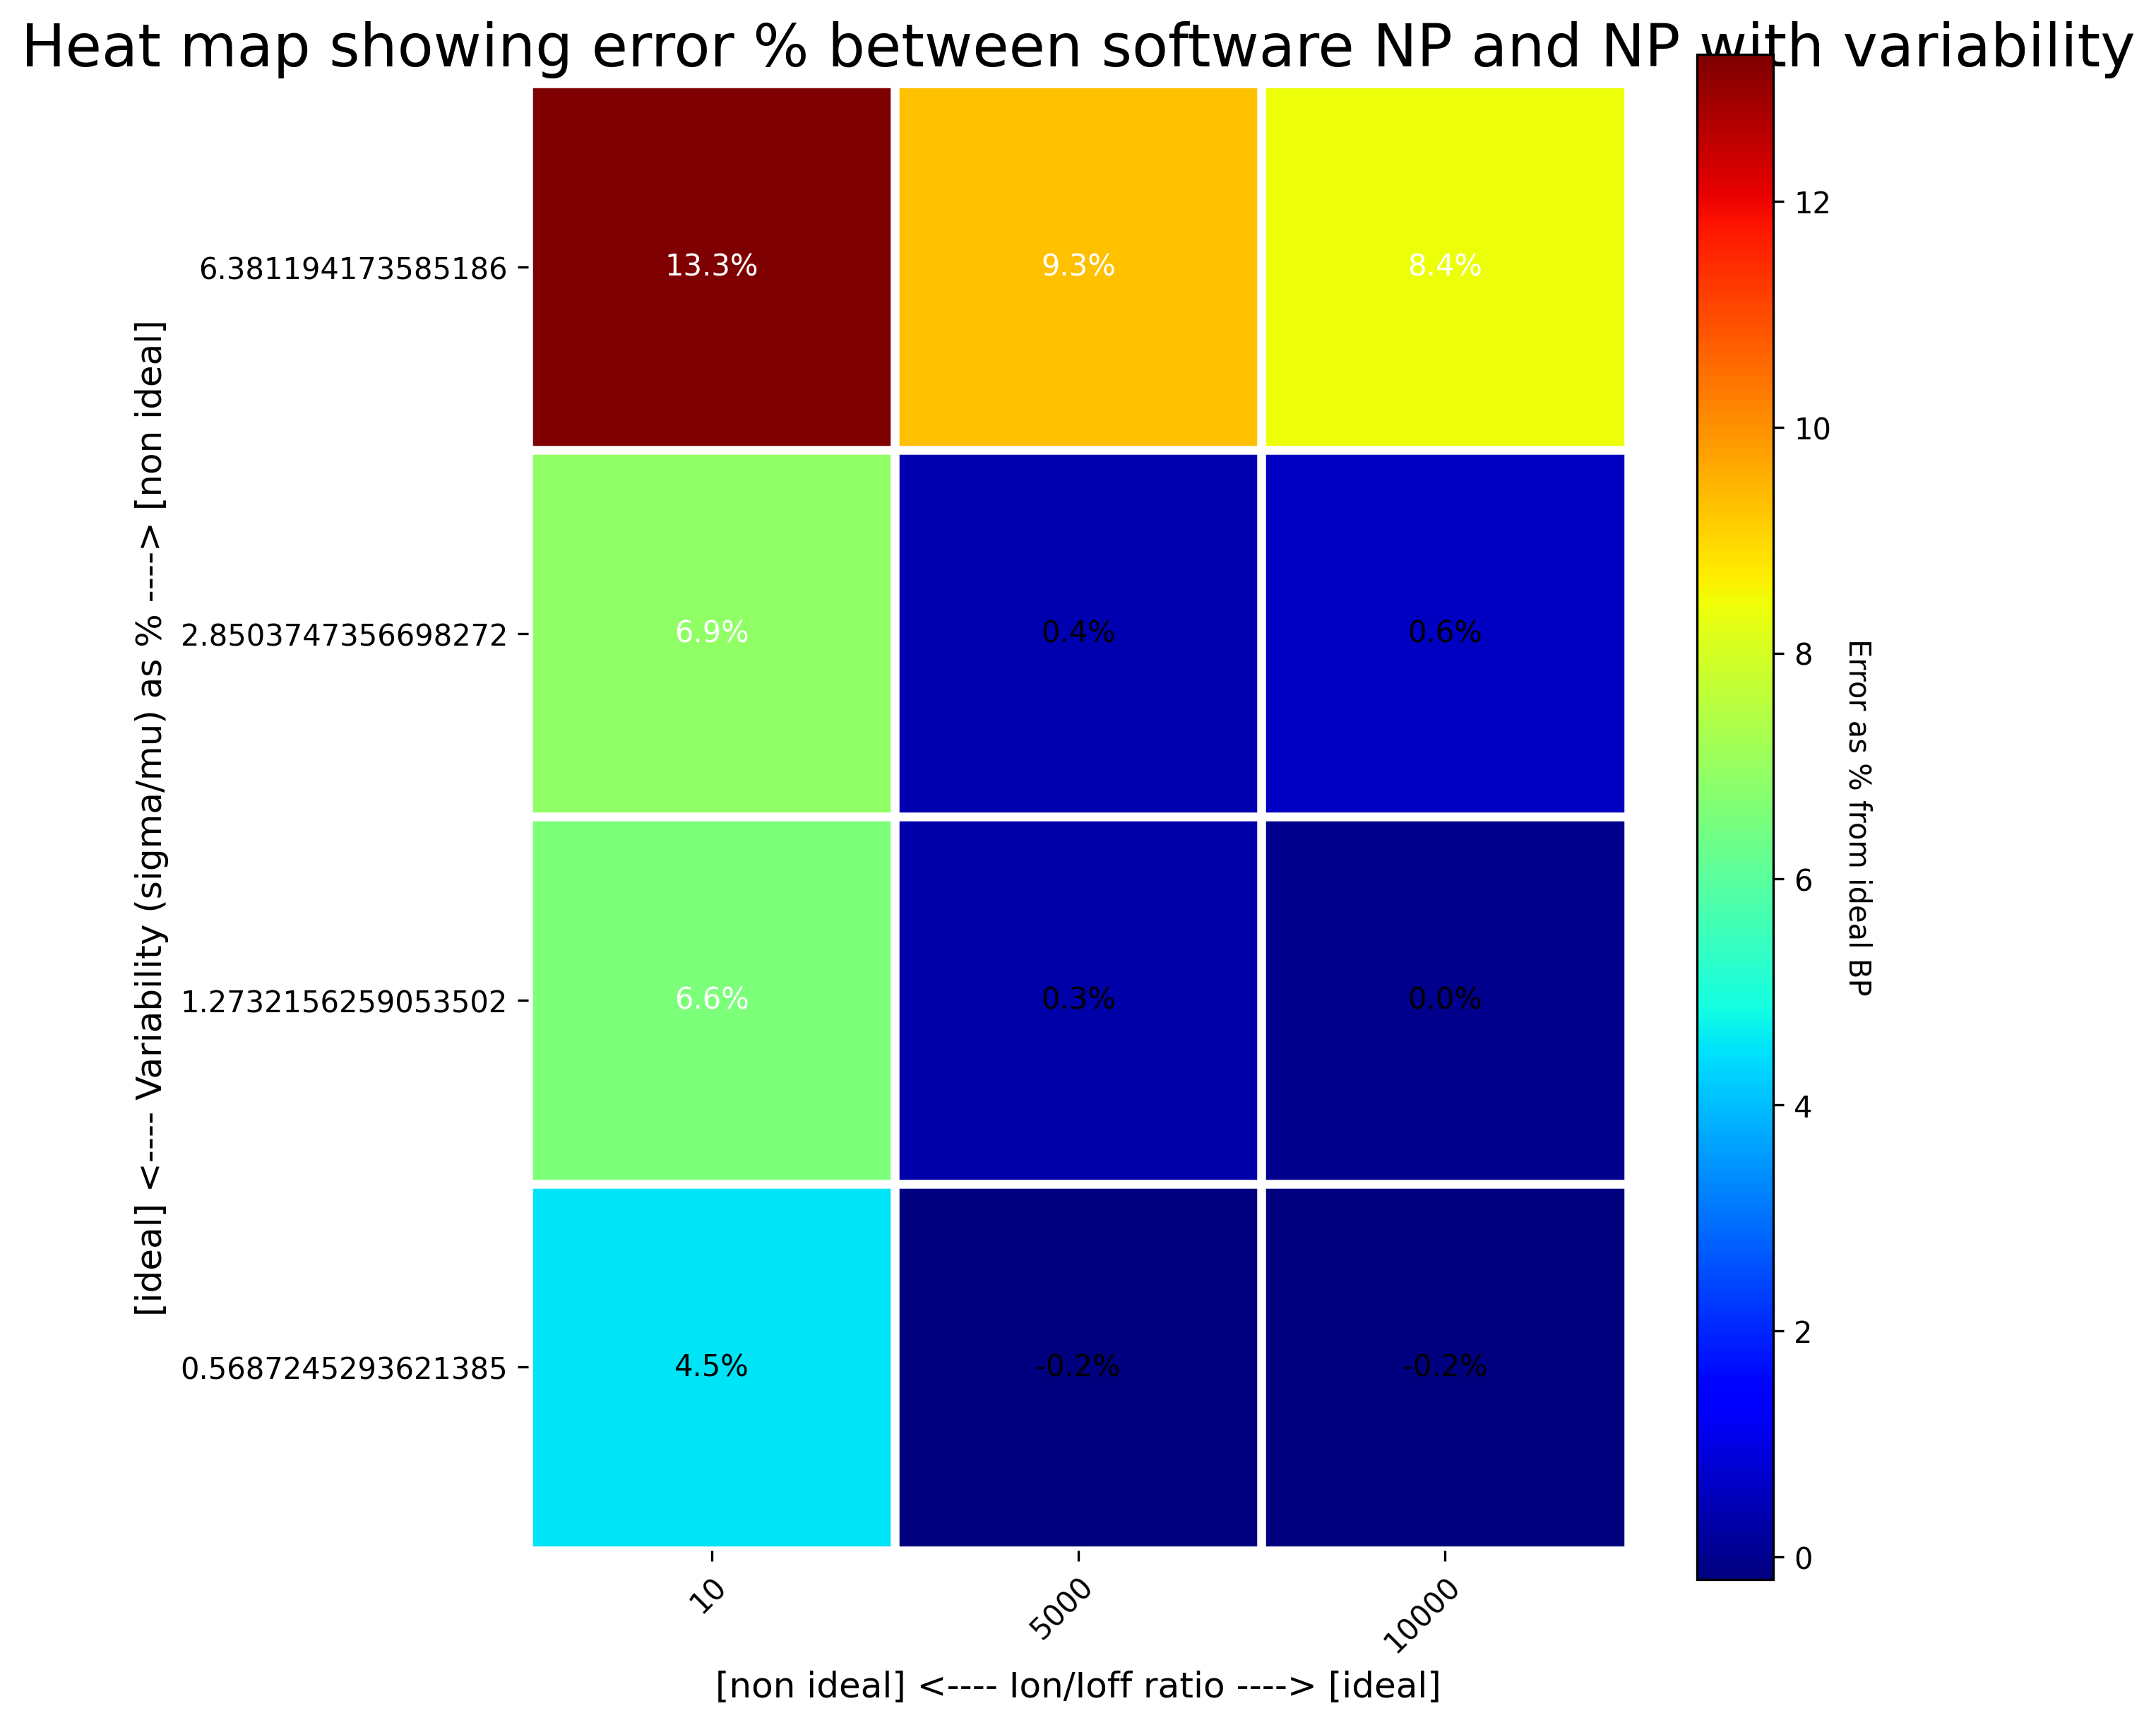

In [115]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(8, 8))

im, cbar = heatmap(np.round(87.45 - trainAccVariNP, 1), (Sigma*100)/0.7, nf, ax=ax,
                   cmap="jet", cbarlabel="Error as % from ideal BP")
texts = annotate_heatmap(im, valfmt="{x:.1f}%")

fig.tight_layout()
plt.xlabel("[non ideal] <---- Ion/Ioff ratio ----> [ideal]", fontsize=12)
plt.ylabel("[ideal] <---- Variability (sigma/mu) as % ----> [non ideal]", fontsize=12)
plt.title("Heat map showing error % between software NP and NP with variability", fontsize=20)
plt.gcf().set_dpi(300)
plt.show()

In [204]:
#Sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
Sigma = 10**(-np.arange(1, 3.8, 0.35)[1:])
#nf = [10, 100, 1000, 10000, 100000]
prec = np.array([2,4,6,7, 8,9, 10, 11,12,14, 16])
trainAccSoft, trainAccVariNP1, valAccSoft, valAccVariNP1 = np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec)))
for j in range(len(Sigma)):
    for k in range(len(prec)):
        noOfLevels = 2**prec[k]- 1 #no of levels of quantization
        #step = round(wRange/noOfLevels, precision)
        step =  wRange/noOfLevels#step size of each of the step after quantization
        #discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
        discreteSteps = [step*i for i in range(0, noOfLevels)] 
        print(f"Training for sig = {Sigma[j]} prec = {prec[k]} step= {step}")
        trainAccVar, valAccVar,_, _, _ = batchGDCompOCNP(x_train,y_train,5, lrBP, lrNP, 0.00001, mu, Sigma[j], vDD, prec[k], step, discreteSteps, wRange, onoff = 1000000,print_op=1)
        trainAccSoft[j, k] = trainAccVar[-1][0]
        trainAccVariNP1[j, k] = trainAccVar[-1][1]
        valAccSoft[j, k] = valAccVar[-1][0]
        valAccVariNP1[j, k] = valAccVar[-1][1]

Training for sig = 0.0446683592150963 prec = 2 step= 0.6666666666666666
Params Initialised
Iteration: 1::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::8.976 Val Acc BP var::9.729
Iteration: 2::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::8.976 Val Acc BP var::9.729
Iteration: 3::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::8.976 Val Acc BP var::9.729
Iteration: 4::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::8.976 Val Acc BP var::9.729
Iteration: 5::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc BP var::8.976 Val Acc BP var::9.729
Training for sig = 0.0446683592150963 prec = 4 step= 0.13333333333333333
Params Initialised
Iteration: 1::Train accuracy(software BP): 14.014::Val accuracy: 15.5:#########################:Train Acc B

KeyboardInterrupt: 

<Figure size 864x864 with 0 Axes>

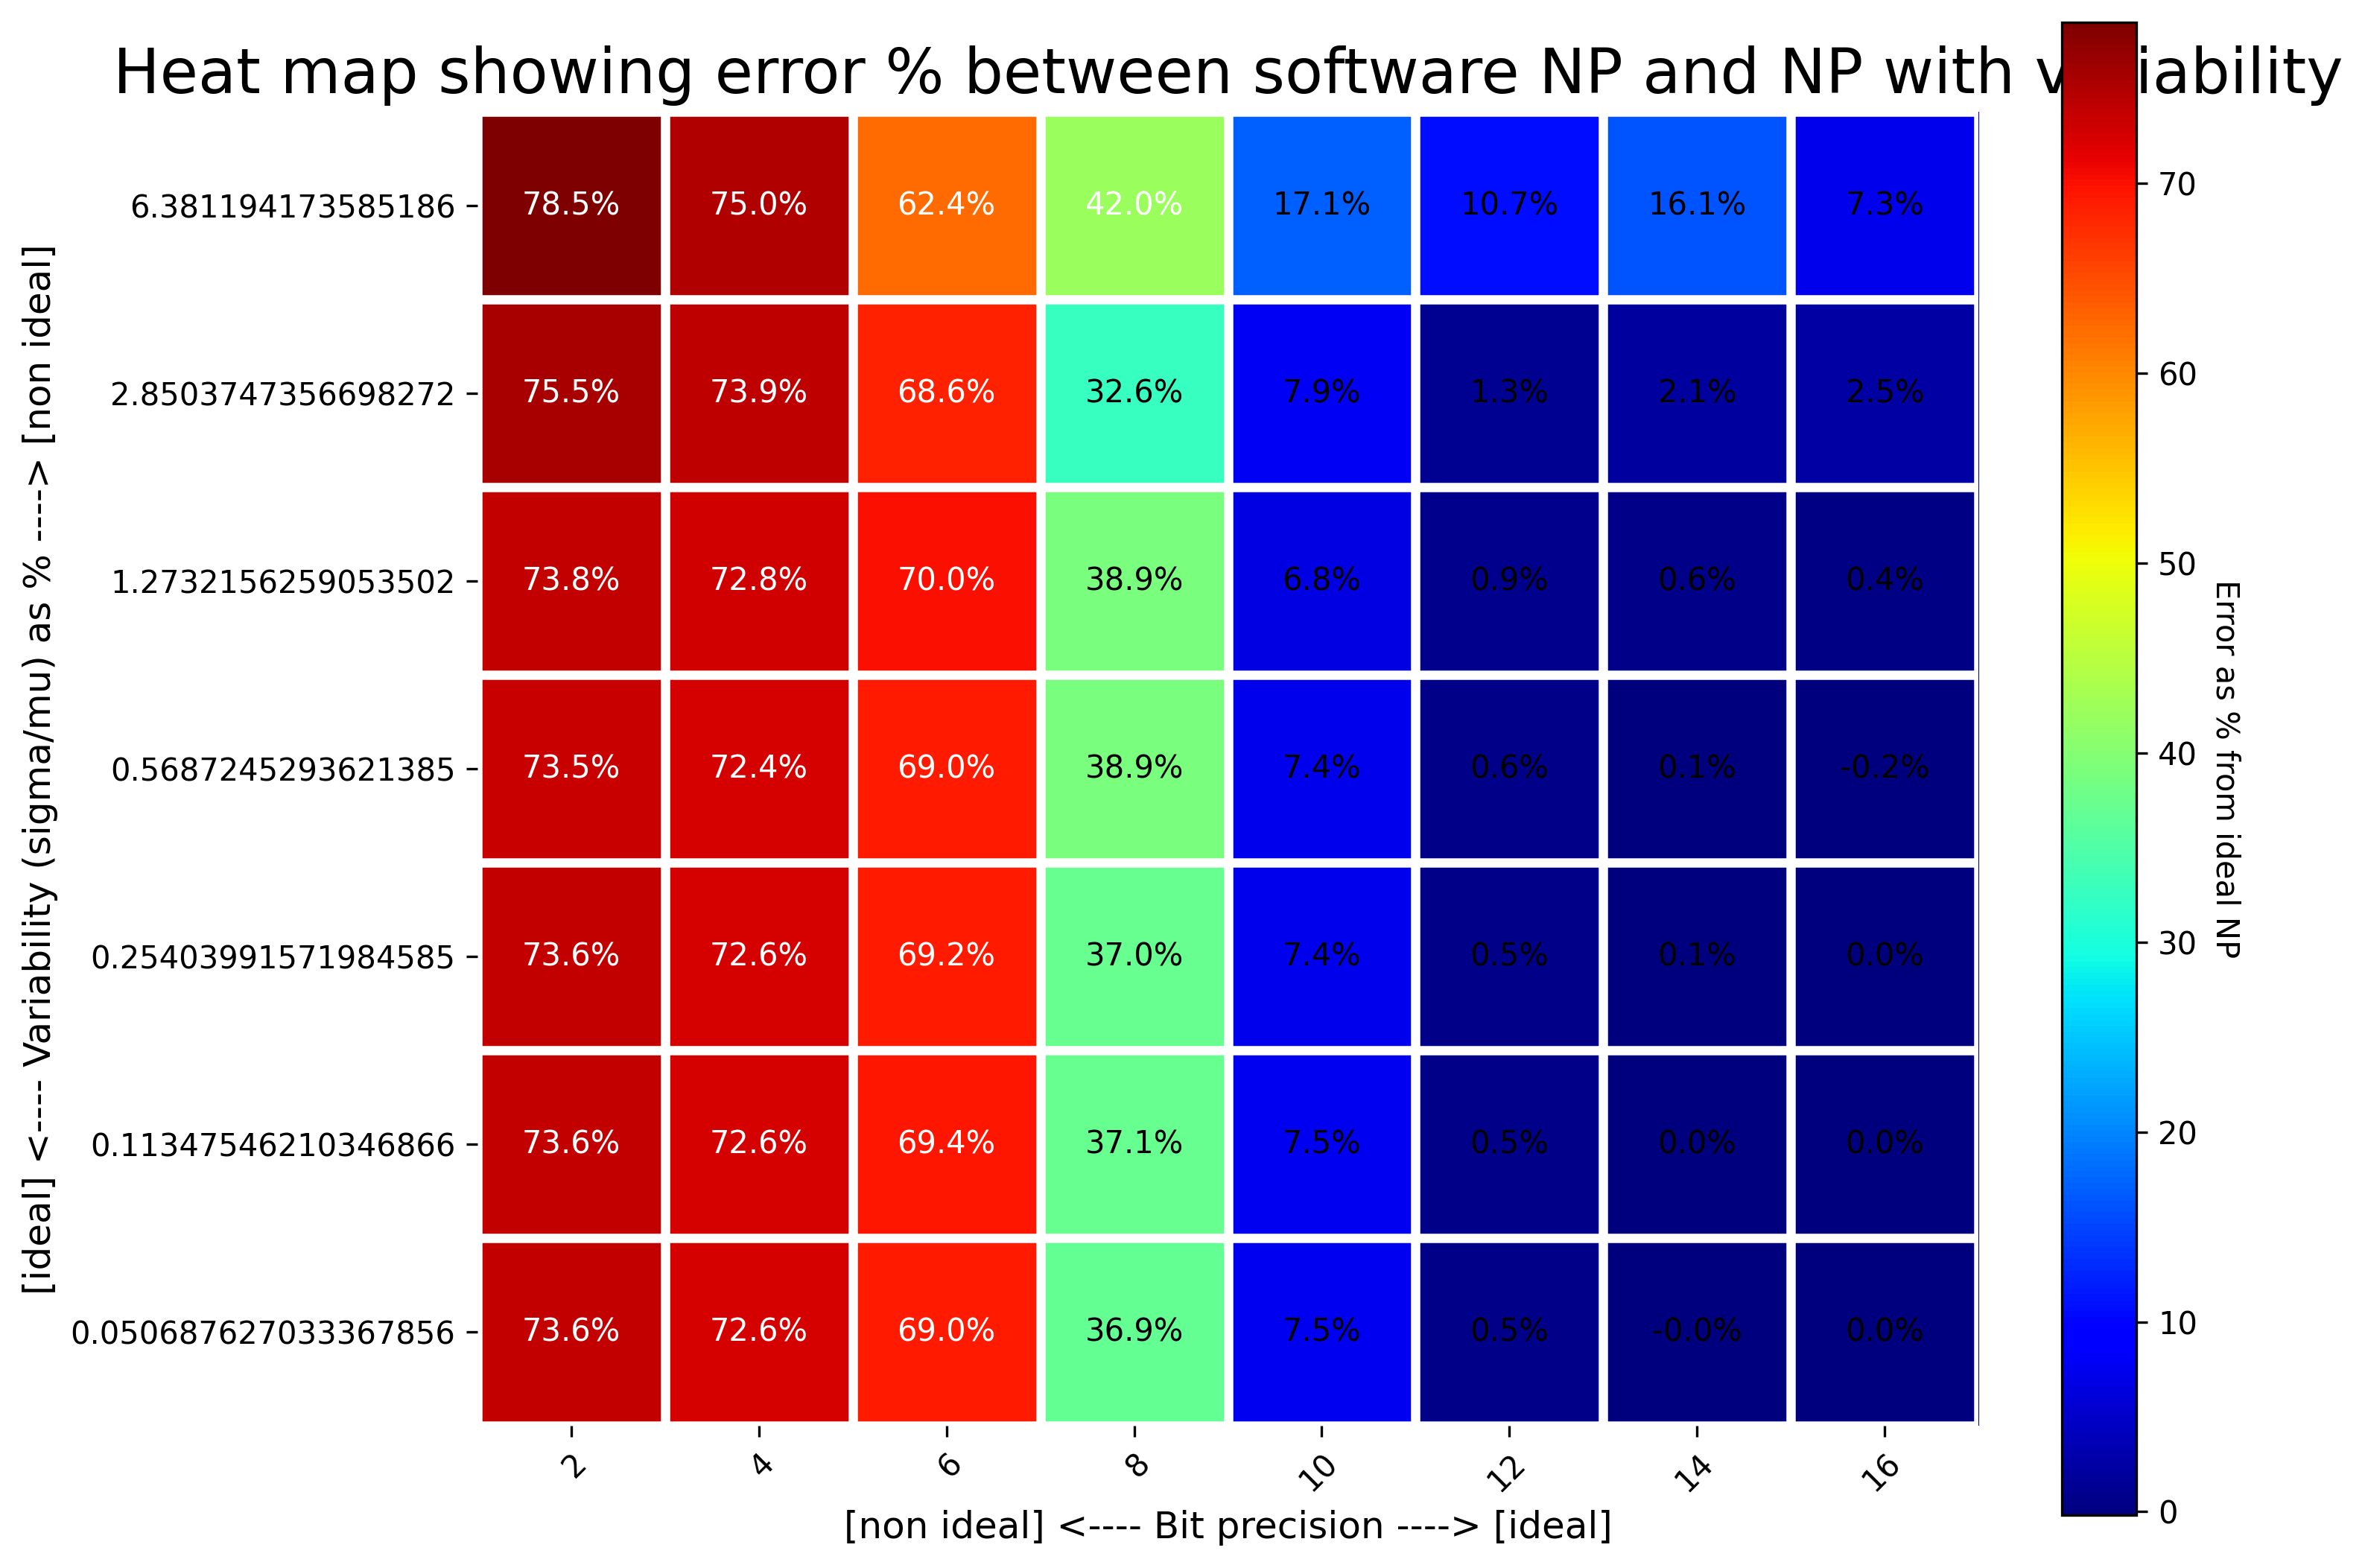

In [ ]:
plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(10, 10))

im, cbar = heatmap(np.round(87.454 - trainAccVariNP1, 1), (Sigma*100)/0.7, prec, ax=ax,
                   cmap="jet", cbarlabel="Error as % from ideal NP")
texts = annotate_heatmap(im, valfmt="{x:.1f}%")

fig.tight_layout()
plt.xlabel("[non ideal] <---- Bit precision ----> [ideal]", fontsize=12)
plt.ylabel("[ideal] <---- Variability (sigma/mu) as % ----> [non ideal]", fontsize=12)
plt.title("Heat map showing error % between software NP and NP with variability", fontsize=20)
plt.gcf().set_dpi(300)
plt.show()

In [198]:
np.meshgrid((Sigma*100)/0.7, np.array(prec)), np.round(87.454 - trainAccVariNP1.T, 1)

([array([[6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763],
         [6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763],
         [6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763],
         [6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763],
         [6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763],
         [6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763],
         [6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763],
         [6.38119417, 2.85037474, 1.27321563, 0.56872453, 0.25403992,
          0.11347546, 0.05068763]]),
  array([[ 2,  2,  2,  2,  2,  2,  2],
         [ 4,  4,  4,  4,  4,  4,  4],
         [ 6,  6,  6,  6,  6,  6,  6],
         [ 8,  8,  8,  8,  8,  8,  8],
  

In [197]:
fig = plt.figure(figsize=(12,12))
plt.gcf().set_dpi(300)
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid((Sigma*100)/0.7, np.array(prec))
print(X.shape, Y.shape, trainAccVariNP1.shape)
ax.plot_surface(X, Y, np.round(87.454 - trainAccVariNP1.T, 1),cmap='summer', rstride=1, cstride=1)

(8, 7) (8, 7) (7, 8)
